# Implémentez un modèle de scoring

- **Projet 7 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Étape 2 : Modélisation


## 1.1 Compréhension du problème

### 1.1.1 Problématique

La société financière, nommée **"Prêt à dépenser"**, propose des crédits à la consommation pour des
personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre **un outil de “scoring crédit”** pour calculer la qu’un client
rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc
développer **un algorithme de classification** en s’appuyant sur des sources de données variées (données
comportementales, données provenant d'autres institutions financières, etc.).

### 1.1.2 Les données

Voici [les données](https://www.kaggle.com/c/home-credit-default-risk/data) pour réaliser le
dashboard. Pour plus de simplicité, vous pouvez les télécharger à
[cette adresse](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip).

### 1.1.1 Mission

- Sélectionner un kernel Kaggle pour faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring.
- Analyser ce kernel et l’adapter aux besoins de votre mission.

Focalise sur :

1. La construction d'un **modèle de scoring** qui donnera une prédiction sur la probabilité de faillite
   d'un client de façon automatique.
   - élaboration
   - optimisation
   - comprehension (interpretabilité)
2. Construction d'un **dashboard interactif** qui montre avec transparence les décisions d’octroi de
   crédit, à destination des gestionnaires de la relation client permettant d'interpréter les
   prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation
   client.


## 1.2 Definition de l'environnement

- `local` : Développement local (avec échantillon de 50 Mo de données)
- `colab` : Google Colab
- `kaggle` : Kaggle Kernel


In [10]:
ENV = 'local'

# if ENV == 'local':
# local development
DATA_FOLDER = '../data/raw'
OUT_FOLDER = '../data/out'
IMAGE_FOLDER = '../images/modelisation'
MODEL_FOLDER = '../saved_models'

if ENV == 'colab':
    # Colaboratory - uncomment les 2 lignes suivant pour connecter à votre drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    DATA_FOLDER = '/content/drive/MyDrive/data/OC7'
    OUT_FOLDER = '/content/drive/MyDrive/data/OC7'
    MODEL_FOLDER = '/content/drive/MyDrive/data/OC7/saved_models'
    IMAGE_FOLDER = '/content/drive/MyDrive/images/OC7/modelisation'


## 1.3 Fichiers de données

1. Les données en format CSV (>700Mb compactés) sont à télecharger de ce lien:

- https://www.kaggle.com/c/home-credit-default-risk/data
- Pour plus de simplicité, vous pouvez les télécharger à [cette adresse.](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

2.  Placer le fichier compacté (**.zip**) dans le **DATA_FOLDER** défini ci-dessous


### Noms des fichiers de données (identique pour nettoyage et l'analyse exploratoire)

- Le grand fichier zip des données doit être placé dans `DATA_FOLDER` au préalable
- Tous les autres fichiers de données sont téléchargés ou crées pendant le nettoyage, puis enregistrés dans `OUT_FOLDER`


In [11]:
# Données (DATA_FOLDER)
ZIPPED_DATA_FILENAME = f'Projet+Mise+en+prod+-+home-credit-default-risk.zip'
RAW_DATA_FILENAME = 'HomeCredit_columns_description.csv'
SAMPLE_DATA_FILENAME = 'HomeCredit_columns_description.csv'


# Données nettoyés (OUT_FOLDER)
CLEAN_DATA_FILENAME = 'cleaned_data_scoring.csv'
CLEAN_DATA_SAMPLE = 'cleaned_data_sample.csv'  # 100,000 registres
CLEAN_DATA_FEATURES = 'cleaned_data_features.csv'  # 100 meilleur features
SAMPLE_SIZE = 30000


## 1.4 Requirements: Bibliothèques utilisées dans ce notebook

Ce notebook marche a été testé en developpement local, sur Google Colab et Kaggle

```txt
# copy dans un fichier requirements.txt, puis
# !pip install -r requirements.txt
```


In [12]:
# Decommentarise la ligne suivant si vous ne voulez pas changer vos versions existants
# !pip install numpy pandas matplotlib seaborn scipy sklearn missingno requests


In [13]:
# import local functions
import outils_io
outils_io.install_libraries({'numpy', 'pandas', 'matplotlib',
                             'seaborn', 'scikit-learn', 'imbalanced-learn',
                              'lightgbm', 'yellowbrick', 'shap'})


required modules: ['pandas', 'seaborn', 'scikit-learn', 'imbalanced-learn', 'shap', 'lightgbm', 'numpy', 'yellowbrick', 'matplotlib']
missing modules: []


## 1.5 Import dependencies


### 1.5.1 Import des bibliothèques utilisées par ce notebook


In [14]:
# suppress furture warnings de pandas 1.3.0
from contextlib import contextmanager
import time as time_module
import gc
import os
import warnings
import platform
import pickle
warnings.simplefilter(action='ignore', category=FutureWarning)


In [15]:
import sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

# feature preprocessing
from sklearn import impute
from sklearn import preprocessing

# feature et parameter selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
import imblearn, sklearn, yellowbrick,lightgbm, shap
# Sampling (SMOTE : Synthetic Minority Oversampling TEchnique)
from imblearn import pipeline as imbpipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

# metrics de performance
from sklearn import metrics
from sklearn.metrics import make_scorer, roc_auc_score


# Candidate models
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier


### 1.5.2 Liste des versions des bibliothèques utilisées


In [16]:
print(f'python version = {platform.python_version()}')
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


python version = 3.7.13
versions des bibliothèques utilisées:
platform==1.0.8; sklearn==1.0.2; seaborn==0.11.2; pandas==1.3.5; numpy==1.21.6; imblearn==0.9.0; yellowbrick==1.4; lightgbm==3.3.2; shap==0.40.0


### 1.5.3 Configuration défauts d'affichage


In [17]:
from sklearn import set_config
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 20 lignes
pd.set_option('display.max_colwidth', 800)

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")

set_config(display='diagram')
# displays HTML representation in a jupyter context


### Bibliothèque personelle

On utilise un nom non standard


In [18]:
import outils_io
import outils_preprocess
import outils_stats
import outils_timed
import outils_vis

# frequently used functions
from outils_vis import to_png
from outils_timed import timer


### Configuration personelle


In [19]:

# Enregistre parametres globals dans outils
outils_vis.set_option('IMAGE_FOLDER', IMAGE_FOLDER)
outils_vis.set_option('SAVE_IMAGES', True)

if ENV != 'kaggle':
    outils_io.os_make_dir(DATA_FOLDER)
    outils_io.os_make_dir(OUT_FOLDER)

outils_io.os_make_dir(IMAGE_FOLDER)

RANDOM_SEED = 42


## Fonctions utilitaires


### Test si un séries est log scale

- utilisé pour l'échelle des validation curves des hyperparamètres


In [20]:
# import numpy as np
ArrayLike = npt.ArrayLike or list or range

def is_log_scale(series:ArrayLike)-> bool:
    """Test si series est log scale"""
    try:
        if isinstance(series, pd.Series):
            series = series.values
        # suppose les valeurs au fin sont plus grand
        dif1 = series[-1] / series[-2]
        dif2 = series[-2] / series[-3]
        return round(dif1/dif2, 2) == 1.
    except:
        return False


print(is_log_scale([0, 1]))
print(is_log_scale(range(1, 10)))
print(is_log_scale(np.logspace(2, 8, 10)))


False
False
True


In [21]:
import math


def round_digits(a_number, significant_digits=2):
    # https://stackoverflow.com/questions/374316/round-a-double-to-x-significant-figures
    try:
        return round(a_number, significant_digits - int(math.floor(math.log10(abs(a_number)))) - 1)
    except:
        # infinity, zero, NaN
        return a_number


In [22]:
# import time as time_module
def get_time():
    """
    return time now, without errors caused by references to time everywhere
    """
    now = time_module.time()
    return now


In [23]:
import textwrap

def add_text(ax, x, y, s, wrap=64,**kwargs):
    """Ajouter du texte à un plot"""
    s = textwrap.fill(s, wrap)
    ax.text(x, y, s, verticalalignment='bottom',
            horizontalalignment='left', transform=ax.transAxes, **kwargs)


### Save / Load models

In [24]:

def save_pickle(obj, filename, filepath=MODEL_FOLDER):
    with open(f'{filepath}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_pickle(filename, filepath=MODEL_FOLDER):
    with open(f'{filepath}/{filename}.pickle', 'rb') as handle:
        return pickle.load(handle)

# Import des données nettoyés


In [25]:
# Set SAMPLE=True for Rapid Development
SAMPLE = True

full_data_path = f'{OUT_FOLDER}/{CLEAN_DATA_FILENAME}'  # > 700 variables
best_data_path = f'{OUT_FOLDER}/{CLEAN_DATA_FEATURES}'  # les top 100 features
# echantillon pour developpement rapide
sample_data_path = f'{OUT_FOLDER}/{CLEAN_DATA_SAMPLE}'

cleaned_data_path = sample_data_path if SAMPLE else best_data_path
with timer('Load cleaned data'):
    df_data = pd.read_csv(cleaned_data_path)


Load cleaned data - done in 1s


In [26]:
with timer('Reduce memory'):
    # df_data = outils_preprocess.reduce_memory(df_data)
    df_data = outils_preprocess.reduce_mem_usage(df_data)


Initial df memory usage is 6.03 MB for 79 columns
Final memory usage is: 2.34 MB - decreased by 61.2%
Reduce memory - done in 0s


## Create X (fields), y (target)


In [27]:
def create_X_y(df: pd.DataFrame):
    df = df.set_index('SK_ID_CURR')
    target = df['TARGET'].copy()
    fields = df.drop(columns=['TARGET'])
    return fields, target


X, y = create_X_y(df_data)
print(X.shape)
print(y.shape)


(10000, 77)
(10000,)


In [28]:
def sample_data(df_x: pd.DataFrame, y_: pd.Series, nb=10000):
    """
    Obtenir un échantillon de X et y pour des statistiques
    pour eviter d'alourdir la traitement
    """
    nb = min(nb, len(df_x))
    target = y_.name
    df_x = df_x.join(y_)
    df_sample = df_x.sample(n=nb, random_state=RANDOM_SEED)
    y_sample = df_sample[target]
    x_sample = df_sample.drop(columns=target)
    return x_sample, y_sample


# test
x_sample, y_sample = sample_data(X, y)
print(x_sample.shape)
print(y_sample.shape)

# del x_sample,y_sample


(10000, 77)
(10000,)


In [29]:
TARGET_CLASSES = ['0=repaid', '1=not repaid']
le = preprocessing.LabelEncoder()
target_classes = le.fit_transform(TARGET_CLASSES)
print(target_classes)
print(le.inverse_transform(target_classes))


[0 1]
['0=repaid' '1=not repaid']


## Division en jeux de données d'entraînement et de test

Avant d'encoder les variables catégoriques, et normaliser les variables, il faut diviser entre données d'entrainement et test, pour éviter 'data leakage' :

- Entrainement sur les données train
- Utilise les jeux de données test pour simuler des nouvelles observations (donc aucun partage de connaissance entre données train et test)

Pour division entre données d'entrainement et test, on a plusieurs stratégies :

- une division aléatoire (ex 80% entrainement, 20% test) : Mais on risque de mettre beaucoup de créer de bias dans le jeu d'entrainement si il n'est pas répresentatif des classes à prédire

- stratification : Essayer de garantie que le jeu de données d'entrainement ont le même distribution de classes cibles

#### Références

- <https://scikit-learn.org/stable/common_pitfalls.html#data-leakage>
- <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html>
- <https://towardsdatascience.com/how-to-master-the-subtle-art-of-train-test-set-generation-7a8408bcd578>


In [30]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_SEED)


Verifier que la stratification a produit l'effet désiré :


In [31]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


0    0.92025
1    0.07975
Name: TARGET, dtype: float64
0    0.9205
1    0.0795
Name: TARGET, dtype: float64


# Preprocessing de données

On crée un preprocessor pour pouvoir ajuster les paramètres de preprocessing


In [32]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

category_features = cat_selector(x_train)
numerical_features = num_selector(x_train)
target_features = y_train.name

print(f'numerical_features : {len(numerical_features)}')
print(f'category_features : {len(category_features)}')
print(f'target_features : {target_features}')


numerical_features : 77
category_features : 0
target_features : TARGET


In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


def create_preprocessor(num_cols=num_selector, cat_cols=cat_selector):
    """Preprocessor """
    num_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    cat_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoding', OneHotEncoder(dtype=int, sparse=True, handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ],
        remainder='passthrough')
    return preprocessor


preprocessor = create_preprocessor()
preprocessor


ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000020340FCF9C8>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoding',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000020341062848>)])

In [34]:
numeric_pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy="median")),
            ('simple_scale', StandardScaler())
        ]), num_selector),
    ]))
])
numeric_pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('simple_scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020340FCF9C8>)]))])

In [35]:
numeric_pipeline.fit(x_train)
print(numeric_pipeline.feature_names_in_[:5])

# Erreur si on essaie de récuperer les noms de colonnes
# numeric_pipeline.get_feature_names_out(numeric_pipeline.feature_names_in_)


['EXT_SOURCE_3' 'EXT_SOURCE_2' 'EXT_SOURCE_1' 'DAYS_ID_PUBLISH'
 'DAYS_EMPLOYED_PERC']


### Get feature names pour les preprocessors

Pour interpreter les models, il faut savoir les variables après preprocessing.

Malheureusement, beaucoup des transformers de `sklearn` perd leurs feature names

- SimpleImputer, FunctionTransformer, StandardScalar do not implement `get_feature_names_out`
- Ça pose des problèmes pour l'interprétabilité des modèles

L'ordre des features dépend des column selectors et l'ordre des ColumnTransformers

- Avec des 'named transformers' et 'named steps' dans un ordre spécifique, on peut récupérer les noms des features dans l'ordre


In [36]:
def get_features_out(pipe, xtrain_):
    """
    Get column names after preprocessing

    assumes (requires preprocessors with following structure):
    - all named transformers, if present, are in same order as listed below
    - if preprocessor has other transformers, add to list below
    - only final transformer (named 'cat') adds columns, via an encoder step named 'ohe'
    - if imputer is used, it does not add indicator columns
    """

    def get_features_in_(trans: ColumnTransformer, name=None):
        try:
            features = list(trans.named_transformers_[name].feature_names_in_)
        except:
            # named transformer doesn't exist in pipeline, return empty list
            features = []
        return features

    pipe.fit(xtrain_)
    if hasattr(pipe, 'named_steps'):
        trans: ColumnTransformer = pipe.named_steps['preprocessor']
    else:
        trans = pipe
    # SimpleImputer, FunctionTransformer, StandardScalar do not implement get_feature_names_out

    # Get feature names of numeric columns
    num_features = get_features_in_(trans, 'num')
    scale_features = get_features_in_(trans, 'simple_scale')
    log_features = get_features_in_(trans, 'log_scale')
    ordinal_features = get_features_in_(trans, 'ordinal')
    try:
        cat_encoder = trans.named_transformers_['cat']
        ohe = cat_encoder.named_steps['ohe']
        category_features = list(
            ohe.get_feature_names_out(cat_encoder.feature_names_in_))
    except:
        category_features = []
    features_out = (num_features+scale_features + log_features
                    + ordinal_features + category_features)
    return features_out


Test get_features_out


In [37]:
x_transformed = numeric_pipeline.fit_transform(x_train)
x_transformed_columns = get_features_out(numeric_pipeline, x_train)
print(x_transformed.shape)
print(len(x_transformed_columns))
print(x_transformed_columns[:3])


(8000, 77)
77
['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1']


#### Preprocessor avec feature names


In [38]:
def preprocess(pipe: Pipeline, x_train_, x_test_):
    """Preprocess x_train et x_test séparament.
    Exige un pipeline
    Retourner les données transformés comme pandas DataFrames avec feature names"""
    features_out = get_features_out(pipe, x_train_)
    x_train_out = pd.DataFrame(pipe.fit_transform(
        x_train_), columns=features_out, index=x_train_.index)
    x_test_out = pd.DataFrame(pipe.transform(
        x_test_), columns=features_out, index=x_test_.index)
    return x_train_out, x_test_out


In [39]:
def fit_transform_df(df: pd.DataFrame, processor) -> pd.DataFrame:
    """
    Fit et transform un dataframe, sans changer son shape
     Retourner les données transformés comme panda DataFrame
     sans perdre les noms de colonnes et index

     Note, la plupart de processors (MinMaxScalar, Imputer, ...) 
     retourne un numpy array
     Rapidement on perd les noms des features
     """
    return pd.DataFrame(processor.fit_transform(
        df), index=df.index, columns=df.columns)


### Jeux de données preprocessed

Pour a plupart de modèles, il ne faut pas avoir des NaN

On peut remplir les valeurs manquantes par un **'preprocess'** step dans le pipeline,
mais ça complique l'extraction de feature names (SimpleImputer de sklearn ne fourni pas 'get_features_names_out()' )

On remplis les valeurs manquantes avec SimpleImputer (median pour les numeriques, 'missing' pour les catégoriques), puis un rescale.

Note:

- **x_train_prep** == x\*train **\*preprocessed**\_
- **x_test_prep** == x\*test **\*preprocessed**\_

Ca permet d'extraire les feature importances des models


In [40]:
with timer('preprocess data'):
    x_train_prep, x_test_prep = preprocess(preprocessor, x_train, x_test)


preprocess data - done in 0s


# Sampling : Ré-equilibration des classes cible

Il y a environ 800 colonnes de données, la plupart seront insignifiant en importance pour la modèle.

On peut faire feature selection basé sur les données, mais comme les données sont pour la plupart target = 0, ça met plus de poid sur la classe 'loan repaid.

La référence ci-dessous recommande faire la ré-equilibration des classes, via oversampling AVANT feature selection.


"Distribution_de_TARGET_(cleaned_data).png"


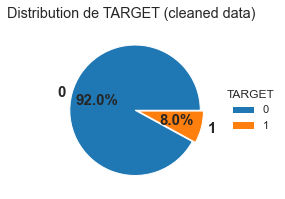

In [41]:
def plot_pie_target(y_: pd.Series, ax=None, figsize=(4, 3), show_counts=False):
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    target_name = getattr(y_, 'name', 'TARGET')
    categs = y_.value_counts()
    nb_colors = len(categs)
    palette = 'tab10' if nb_colors < 11 else 'tab20'
    colors = sns.color_palette(palette, n_colors=nb_colors)
    ax.pie(x=categs, labels=categs.index,
           explode=[0, 0.05],
           autopct=f'%.1f%%', colors=colors,
           startangle=0, textprops=dict(fontsize=15, weight='bold'),
           )
    if show_counts:
        labels = [f'{categ} (nb={categs[categ]})' for categ in categs.index]
    else:
        labels = categs.index
    ax.legend(title=target_name, labels=labels,
              loc='center left', bbox_to_anchor=(1, 0.5))


plot_pie_target(y)
plt.suptitle('Distribution de TARGET (cleaned data)')
to_png()


#### Références

- [SMOTE for high-dimensional class-imbalanced data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3648438/)


## Options de sampling

On a plusieurs stratégies de sampling possible pour équilibré le poid des classes

**Weights**

- ajout plus de poids pour les observations minoritaires

**Random undersampling**

- éliminaire aléatoirement des observations majoritaires

**Random oversampling**

- ajout aleatoirement aux données des copies d'observations minoritaires

**Synthetic Minority Oversampling Technique (SMOTE)**

- ajout des observations minoritaires similaires mais distinctes des observations minoritaires existantes

**SMOTE Tomek**

- oversample, puis undersample les bordeline cas

**ADASYN**

- SMOTE + small randomness

### References

- <https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/>
- <https://towardsdatascience.com/how-to-effectively-predict-imbalanced-classes-in-python-e8cd3b5720c4>


### Créer des instances des samplers


In [42]:
# Random undersampling majority class
undersampler = RandomUnderSampler(random_state=RANDOM_SEED)

# Random oversampling minority class
oversampler = RandomOverSampler(random_state=RANDOM_SEED)

# Synthetic Minority Oversampling Technique (SMOTE)
smote_auto = SMOTE(random_state=RANDOM_SEED)

# over-sample borderline samples using SMOTE, then undersample by removing Tomek links)
smote_tomek = SMOTETomek(random_state=RANDOM_SEED)

# SMOTE with randomness
smote_adasyn = ADASYN(random_state=RANDOM_SEED)


### Oversample les données sans valeurs manquantes (NaN)


oversample - done in 0s
(10000, 77)
(8000, 77)
(14724, 77)


Text(0.5, 0.98, 'Distribution de TARGET après SMOTE (auto)')

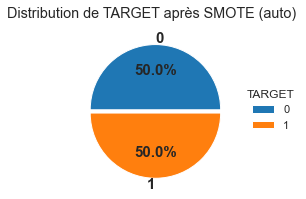

In [43]:
from imblearn import over_sampling

oversampler = over_sampling.SMOTE()
with timer(title='oversample'):
    x_train_smote, y_train_smote = oversampler.fit_resample(
        x_train_prep, y_train)


print(X.shape)
print(x_train.shape)
print(x_train_smote.shape)
plot_pie_target(y_train_smote)
plt.suptitle('Distribution de TARGET après SMOTE (auto)')


### Créer des samples équilibrées

On ne peut pas utiliser les samplers dans `sklearn.pipeline.Pipeline`,
car sklearn pipeline va undersample ou oversample non seulement sur x_train, mais aussi sur **x_test**.

Il faut utiliser les pipelines de imblearn, qui applique une strategie de under ou oversampling **seulement sur le jeu de données d'entrainement**, mais pas le jeu de données test . Par exemple:

```python
lr_pipeline = imbpipeline.Pipeline(steps=[
    ('preprocess',numeric_pipeline),
    ('sampling', undersampler),
    ('feat_select','passthrough'),
   ('clf', LogisticRegression(class_weight=None)),
])
```

L'avantage d'utiliser un pipeline, c'est qu'on peut faire des gridsearch sur chaque un des **steps**, par exemple, en modifiant le sampler:

```python
param_grid = {
    'sampling': [undersampler, oversampler, smote_auto, smote_tomek],
    'clf__alpha': np.logspace(-5,3,20)
}

```


Create and compare target samples - done in 8s


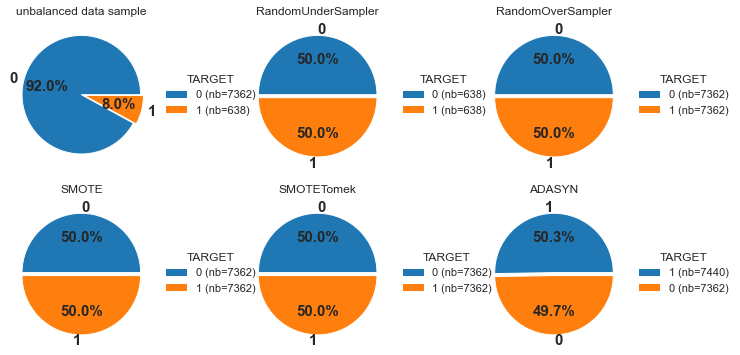

In [44]:
def plot_compare_target_samples(x_, y_, sample_size=10000):
    nb = len(x_)
    sample_size = min(nb, sample_size)
    x_ = x_.sample(sample_size, random_state=RANDOM_SEED)
    y_ = y_.sample(sample_size, random_state=RANDOM_SEED)
    undersampler = RandomUnderSampler(sampling_strategy='majority')
    oversampler = RandomOverSampler(sampling_strategy='minority')

    # SMOTE :
    # oversample with automatic adjustment
    smote_auto = SMOTE(sampling_strategy='auto')

    # over-sample borderline, then undersample both classes by removing Tomek links)
    smote_tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='all'))
    _, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
        nrows=2, ncols=3, figsize=(12, 6))
    plot_pie_target(y_, ax=ax1, show_counts=True)
    ax1.set_title('unbalanced data sample')

    axs = [ax2, ax3, ax4, ax5, ax6]
    for n, sampler in enumerate([undersampler, oversampler, smote_auto, smote_tomek, smote_adasyn]):
        sampler_name = sampler.__class__.__name__
        x_sampled, y_sampled = sampler.fit_resample(x_, y_)
        ax = axs[n]
        plot_pie_target(y_sampled, ax=ax, show_counts=True)
        ax.set_title(sampler_name)


with timer('Create and compare target samples'):
    plot_compare_target_samples(x_train_prep, y_train)


## Construction d'un model pipeline avec SMOTE

References

- <https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7>
- <https://stackoverflow.com/questions/50245684/using-smote-with-gridsearchcv-in-scikit-learn>


In [45]:
from imblearn import pipeline as imbpipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
# from sklearn.svm import LinearSVC
# test model pipeline avec un classifier rapide
from sklearn.linear_model import RidgeClassifier


def create_model(
    sampling=SMOTE(random_state=RANDOM_SEED),
    preprocessor=numeric_pipeline,
    feature_selector=SelectKBest(score_func=f_classif, k=50),
    classifier=RidgeClassifier()
):
    model = imbpipeline.Pipeline(steps=[
        ('sampling', sampling),
        ('preprocess', preprocessor),
        ('feat_select', feature_selector),
        ('clf', classifier)
    ])
    # ('feat_select', SelectFromModel(LGBMClassifier, max_features=100)),
    return model


test_model = create_model(preprocessor=preprocessor)
test_model


Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020340FCF9C8>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(dtype=<class 'int'>,
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020341062848>)])),
                ('feat_select', SelectKBest(k=50)),
                ('clf', RidgeClassifier())])

In [46]:
stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=RANDOM_SEED)


param_grid = {'clf__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=test_model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           verbose=2,
                           return_train_score=True,
                           n_jobs=-1)

with timer('Gridsearch on sampling pipeline'):
    grid_search.fit(x_train_prep, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(x_test_prep, y_test)
result = {'cv_score': cv_score, 'test_score': test_score}
print(f'cv_score : {cv_score:.3f}, test_score : {test_score:.3f}')
print('best_estimator type : ', type(grid_search.best_estimator_))


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Gridsearch on sampling pipeline - done in 49s
cv_score : 0.709, test_score : 0.720
best_estimator type :  <class 'imblearn.pipeline.Pipeline'>


In [47]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=RidgeClassifier(),
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           verbose=2,
                           return_train_score=True,
                           n_jobs=-1)

with timer('Gridsearch on sampling pipeline'):
    grid_search.fit(x_train_prep, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(x_test_prep, y_test)
result = {'cv_score': cv_score, 'test_score': test_score}
print(f'cv_score : {cv_score:.3f}, test_score : {test_score:.3f}')
print('best_estimator type : ', type(grid_search.best_estimator_))


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Gridsearch on sampling pipeline - done in 1s
cv_score : 0.728, test_score : 0.734
best_estimator type :  <class 'sklearn.linear_model._ridge.RidgeClassifier'>


## Construction de sample sets

Comme on peut voit ci-dessus, le gridsearch devient très chronophage si on met le preprocessing (imputation), sampling, et feature selection dans le pipeline.

Comme notre objective est d'optimiser les hyperparametres pour un classificateur, il sera mieux d'eviter de reconstruire le dataset a chaque run.

Donc, pour accèlerer la processus de gridsearch, on va créer des datasets équilibrées en amont


In [48]:
# 1. Create X, y from dataframe
x, y = create_X_y(df_data)
x_sample, y_sample = sample_data(X, y, nb=SAMPLE_SIZE)

# 2. Split data
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
x_train_sample, x_test_sample, y_train_sample, y_test_sample = train_test_split(
    x_sample, y_sample, test_size=0.2, stratify=y, random_state=RANDOM_SEED)


# 3. Preprocess data (impute, optionally rescale)
# set 1 - sans ré-equilibrage
x_train_prep, x_test_prep = preprocess(numeric_pipeline, x_train, x_test)

# subsample (size= 10000) without re-balancing - for testing pipelines / visualisation
x_train_sample, x_test_sample = preprocess(
    numeric_pipeline, x_train_sample, x_test_sample)

# 4. Sample data
# Note: sample only training dataset; the test dataset remains imbalanced

# Set 2 - random undersample
x_train_under, y_train_under = undersampler.fit_resample(x_train_prep, y_train)

# Set 3 - random oversample
x_train_over, y_train_over = oversampler.fit_resample(x_train_prep, y_train)

# Set 4 - SMOTE oversample minority class
x_train_smote, y_train_smote = smote_auto.fit_resample(x_train_prep, y_train)

# Set 5 - SMOTE_Tomek
x_train_tomek, y_train_tomek = smote_tomek.fit_resample(x_train_prep, y_train)

# Set 6 - SMOTE ADASYN
x_train_adasyn, y_train_adasyn = smote_adasyn.fit_resample(
    x_train_prep, y_train)


for df in [x_train_sample, x_train_under, x_train_over, x_train_smote, x_train_adasyn]:
    print(df.shape)


(8000, 77)
(1276, 77)
(14724, 77)
(14724, 77)
(14802, 77)


# Feature sélection

Les performances des modèles ne peuvent pas être comparés basés sur toutes les features, car un modèle utilisant tous les features risque de faire d'overfit, ou ils auront de la variance ajoutée par des features qui n'ont aucun pouvoir prédictif (du 'bruit')

- Filter mèthodes
- Embedded mèthodes
- Wrapper mèthodes


### Filter, Embedded et Wrapper Feature Selection

Il faut donc appliquer une feature selection **avant**, **pendant** ou **pos entrainement** de chaque modèle pour arriver au _**meilleur modèle**_ pour chaque Classifier :

- Pour toutes les modèles, on peut utiliser:
- un 'Filter': par exemple `KBest` Features
- Pour Ridge et LogisticRegression, le feature sélection est 'Embedded' penalty : L1 ou L2 regularisation
- Pour SVC, on peut utiliser 'Wrapper' Recursive Feature Elimination
- Les méthodes ensemblistes (RandomForest, LGBM) utilisent 'Embedded' feature importance selection


Pour n'alourdir pas ce notebook, des tests de feature selection pré-entrainement on été ajoutés au notebook de nettoyage


In [49]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2


def select_k_best_features(x_, y_, k=5, score_func=mutual_info_classif):
    # sel_=SelectKBest(mutual_info_regression,k=k)
    np.seterr(divide='ignore', invalid='ignore')
    sel_ = SelectKBest(score_func=score_func, k=k)
    sel_.fit(x_, y_)
    np.seterr(divide='warn', invalid='warn')
    return x_[x_.columns[sel_.get_support()]]


In [50]:
x_sample, y_sample = sample_data(x_train_smote, y_train_smote, nb=10000)
print(x_train_smote.shape)
print(x_sample.shape)
# make non_negative for chi2
x_sample = fit_transform_df(x_sample, MinMaxScaler())

nb = 10
# display features
with timer('Mutual Info Classification'):
    print(f'\nBest {nb} features basé sur mutual info classification : ')
    print(select_k_best_features(x_sample, y_sample, k=nb,
          score_func=mutual_info_classif).columns.tolist())

with timer('F_Classification'):
    print(f'\nBest {nb} features basé sur classifications individuelle : ')
    print(select_k_best_features(x_sample, y_sample,
          k=nb, score_func=f_classif).columns.tolist())

with timer('Chi2 Classification'):
    print(f'\nBest {nb} features basé sur chi2 individuelle : ')
    print(select_k_best_features(x_sample, y_sample,
                                 k=nb, score_func=chi2).columns.tolist())


(14724, 77)
(10000, 77)

Best 10 features basé sur mutual info classification : 
['EXT_SOURCE_3', 'PREV_NAME_YIELD_GROUP_high_MEAN', 'PREV_CNT_PAYMENT_MEAN', 'BURO_CREDIT_ACTIVE_Closed_MEAN', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'INSTAL_DBD_SUM', 'PREV_NAME_YIELD_GROUP_low_normal_MEAN']
Mutual Info Classification - done in 5s

Best 10 features basé sur classifications individuelle : 
['EXT_SOURCE_2', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'DAYS_LAST_PHONE_CHANGE', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT', 'PREV_DAYS_DECISION_MEAN', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher_education']
F_Classification - done in 0s

Best 10 features basé sur chi2 individuelle : 
['DAYS_BIRTH', 'WALLSMATERIAL_MODE_Panel', 'REG_CITY_NOT_LIVE_CITY', 'OWN_CAR_AGE', 'OCCUPATION_TYPE_Laborers', 'NAME_INCOME_TYPE_Working', 'NAME_INCOME_TYPE_Pensioner', 'NAME_EDUCATION_TYPE_Secondary_second

On voit que la fonction utilisée par KBest change la sélection de features

- mutual_info_regression utilise KNN_regressor (non-lineaire)
- f_regression utilise LinearRegression


### Plot mutual information


In [51]:
from sklearn.feature_selection import mutual_info_classif


def plot_mutual_information(x_, y_, sample_size=10000):
    """Plot mutual information, requires no missing values"""
    # mutual_info_classif peut prend beaucoup de temps
    # pour des grands quantités de données
    nb = min(sample_size, len(x_))
    x_, y_ = sample_data(x_, y_)
    mi = pd.DataFrame(
        {'mutual information': mutual_info_classif(x_, y_)},
        index=x_.columns)
    nb = min(len(mi), 20)
    mi = mi.sort_values(by='mutual information', ascending=False).head(nb)
    sns.barplot(x=mi['mutual information'], y=mi.index)
    sns.despine()
    plt.grid(axis='x')


Mutual Information - done in 5s
"mutual_info_classification,_x_resampled_vs-_TARGET.png"


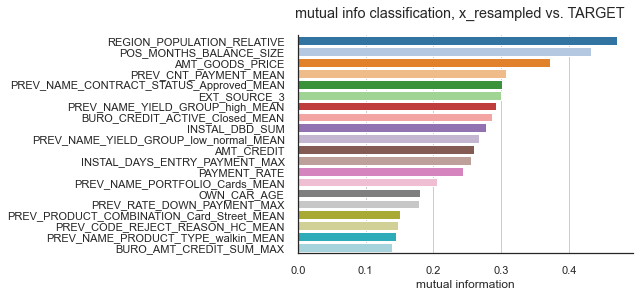

In [52]:
with timer('Mutual Information'):
    plot_mutual_information(x_sample, y_sample)
plt.suptitle(f'mutual info classification, x_resampled vs. TARGET')
to_png()
plt.show()


### Influence d'ajouter des features pour chaque model candidat

- Dans un premier temps, on essayer de determiner l'effet additif des nouveaux variables sur le score du model


In [53]:

from sklearn.model_selection import cross_val_score


def plot_k_best(model_, x_, y_, kmax=10, scoring_='roc_auc',
                kbest_score_func=mutual_info_classif, error_bars=True, show_features=True):
    """Plot la meilleure features pour un modèle donné, basé sur 10 cross_validations"""
    kmax = min(x_.shape[1], kmax)
    k_range = range(1, kmax+1)
    scores = pd.DataFrame([], columns={'k', 'col', 'score_mean', 'score_std'})
    cols = []
    for k in k_range:
        x_best = select_k_best_features(x_, y_, k)
        new_cols = set(x_best.columns)-set(cols)
        # print(f'k={k}, new cols = {new_cols}')
        for col in new_cols:
            cols.append(col)
        cv_scores = cross_val_score(
            model_, x_best, y_, cv=10, scoring=scoring_, error_score=0)
        score_mean = cv_scores.mean()
        score_std = cv_scores.std()
        if scoring_ == 'r2':
            score_mean *= 100
            score_std *= 100
        # elif scoring_.startswith('neg_'):
        #     score_mean *= -1
        scores = scores.append({'k': k, 'col': ','.join(
            new_cols), 'score_mean': score_mean, 'score_std': score_std}, ignore_index=True)

    if show_features:
        sns.scatterplot(data=scores, x='k', y='score_mean', hue='col', alpha=1)
        plt.legend(title='variable ajoutée',
                   bbox_to_anchor=(1.1, 0.5), loc="center left")
    elif error_bars:
        plt.errorbar(data=scores, x='k', y='score_mean', yerr='score_std')
    else:
        sns.scatterplot(data=scores, x='k', y='score_mean')

    if scoring_ == 'r2':
        plt.ylabel("r2 score (% variance explained)")
    # elif scoring_.startswith('neg_'):
    #     plt.ylabel(f'score ({scoring_[4:]})')
    else:
        plt.ylabel(f'score ({scoring_})')

    plt.title("Performance du modèle en fonction de nombre de variables")
    plt.xlabel("nombre de variables sélectionnées (k)")
    sns.despine()
    return scores


In [54]:
def plot_kbest_adaboost():
    from sklearn.ensemble import AdaBoostClassifier
    with timer('AdaBoost - KBest(f_classif)'):
        # quelque minutes
        x_sample, y_sample = sample_data(x_train_prep, y_train, nb=10000)
        cols = plot_k_best(AdaBoostClassifier(), x_sample,
                           y_sample, scoring_='roc_auc', kbest_score_func=f_classif)
    print(cols[:5])
    plt.suptitle('AdaBoost - KBest(f_classif), scoring = roc_auc')
    to_png()

# plot_kbest_adaboost()


Ridge - KBest(f_classif) - done in 27s
   score_std  k  score_mean  \
0   0.033424  1    0.539875   
1   0.030165  2    0.620110   
2   0.033548  3    0.664570   
3   0.032740  4    0.663823   
4   0.023815  5    0.672782   

                                                        col  
0                                              PAYMENT_RATE  
1                                              EXT_SOURCE_3  
2                                              EXT_SOURCE_2  
3  PREV_PRODUCT_COMBINATION_POS_industry_with_interest_MEAN  
4            EMERGENCYSTATE_MODE_No,ACTIVE_DAYS_CREDIT_MEAN  
"RidgeClassifier_-_KBest(f_classif),_scoring_=_roc_auc.png"


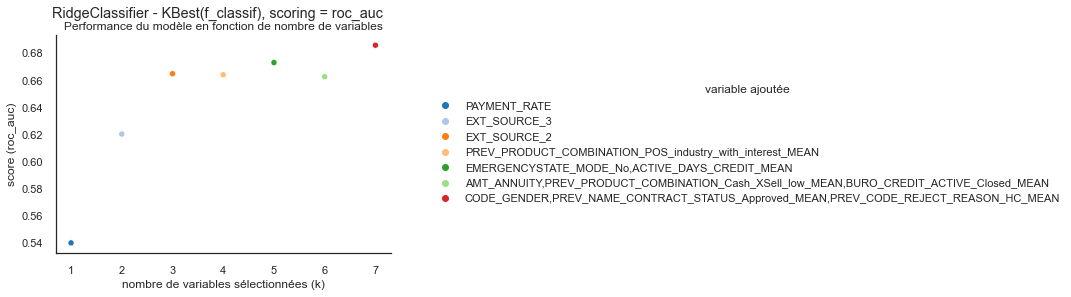

In [55]:
def plot_kbest_ridge():
    from sklearn.linear_model import RidgeClassifier
    with timer('Ridge - KBest(f_classif)'):
        # quelque minutes
        x_sample, y_sample = sample_data(x_train_prep, y_train, nb=10000)
        cols = plot_k_best(RidgeClassifier(), x_sample,
                           y_sample, scoring_='roc_auc', kmax=7, kbest_score_func=f_classif)
    print(cols[:5])
    plt.suptitle('RidgeClassifier - KBest(f_classif), scoring = roc_auc')
    to_png()


plot_kbest_ridge()


### Conclusions sur Feature Selection

Sans optimisation des hyperparamètres, on voit que 4 ou 5 variables domine la performance des modeles (ROC_AUC)


# Les métriques d'évaluation


In [56]:
from sklearn.metrics import SCORERS

print(list(SCORERS))


['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted']


Pour la classification binaire, les métriques pour estimer les erreurs entre y_pred et y_test sont :

**ROC AUC (Area Under the Curve)**

- peut être comparé entre modèles

**log loss**

- logistic loss or cross-entropy loss. Normalement utilisé s'il y a plus de 2 classes dans TARGET

**precision**
Quelle portion du target prédit sont du vrai classe ?

- precision = TP / (TP + FP)

**recall**
Quelle portion du vrai classe sont présent dans le classe prédit ?

- recall = TP / (TP + FN)

**F1-score**
Accuracy équilibré

- F1 = 2 _ (precision _ recall) / (precision + recall)
- F1 = (2 _ TP) / (2 _ TP + FP + FN)

**Fbeta-score**
Generalisation de F1-score pour mettre plus de poids sur precision (ex beta=0.5), ou pour mettre plus de poid sur recall (ex: beta=2)


## Choix de score pour optimiser les modèles

Il y a deux façons d'optimiser les modèles:

- Optimiser l'AUC (Area Under Curve), puis optimiser la seuil (discrimination threshold) pour la profit de la banque
- Optimisation cost-sensitive via une fonction customisée qui prendre en compte déja la profit de la banque.

On va essaie les deux et comparer les performances des meilleurs modeles en simulant la profit total

- Dans le prémier cas, on minimise le nombre de faut positifs et faut negatives pour le jeu de données train
- Dans la deuxieme cas, on maximise la profit pour le jeu de données train, en utilisant un custom scorer qui estime le cout des mauvais classifications pour la banque


## Cost Sensitive learning

_In cost-sensitive learning instead of each instance being either correctly or incorrectly classified, each class (or instance) is given a misclassification cost. Thus, instead of trying to optimize the accuracy, the problem is then to minimize the total misclassification cost._

- Page 50, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.

### Deux méthodes de cost-sensitive learning

- donner un poid à chaque classe (hyperparamètre 'weights' dans les classifiers)
- donner un poids a chaque instance, via un cost_function pour la banque


### Custom Credit Scorer : Optimisation de benefit (score) pour la banque.

Pour la banque, le cout d'un faux positif (donner un prêt à un mauvais payeur) est plus que le cout d'un faux negatif (refuser un prêt à un bon client)

Donc, il faut penaliser les faux positif plus que les faux negatif.

Si on met cette fonction comme le scorer, on est en train de faire un type de 'Cost-sensitive learning', car le custom_credit score n'optimise pas l'accuracy / ROC_AUC : il est un mesure du cout total de misclassification.


In [57]:
def custom_credit_score(y_true_, y_pred_,
                        tn_profit=1, fp_loss=-0.5, fn_loss=-10, tp_profit=0.2,
                        **kwargs):
    """
    Fonction cout metier
    Penalise les prêts qui ne sont pas repayés (perte plus importante que si on ne prend pas un client bon)
    (TN - 0.5*FP - 10*FN + 0.2*TP), normalisé entre 0 et 1
    les arguments tn_profit, fp_loss, fn_loss, tp_profit permet d'ajuster les couts
     (par exemple, si les couts dépend du taille du prêt, on peut créer des nouveaux scorers basé sur ce scorer)
     kwargs is ignored - added just to avoid errors if used to replace roc_auc_score with parameter zero_division = 0
    """
    (TN, FP, FN, TP) = metrics.confusion_matrix(y_true_, y_pred_).ravel()
    # TN = [y_true=0 (bon), y_pred=0 (bon)    ] - les bon clients pour lesquels le banque donne un pret
    # FP = [y_true=0 (bon), y_pred=1 (mauvais)] - petit perte (manque de preter à un bon client)
    # FN = [y_true=1 (mauvais), y_pred=0 (bon)] - grand perte pour la banque (pret à un mauvais client)
    # TP = [y_true=1 (mauvais), y_pred=1 (mauvais)] - mauvais payeurs que la banque refuse un pret

    # On suppose la valeur des prêts fait ou perdus sont identiques

    valeur_par_pret_fait_bon_client = tn_profit
    cout_par_pret_perdu_bon_client = fp_loss
    cout_de_donner_un_pret_au_mauvais_payeur = fn_loss
    # (meilleur reputation)
    valeur_de_refuser_un_pret_au_mauvais_payeur = tp_profit

    profit = (TN * valeur_par_pret_fait_bon_client
              + TP * valeur_de_refuser_un_pret_au_mauvais_payeur)
    loss = (FP * cout_par_pret_perdu_bon_client
            + FN * cout_de_donner_un_pret_au_mauvais_payeur)

    # prets à tous les bons clients, refuser tous les mauvais clients
    max_profit = ((TN + FP) * valeur_par_pret_fait_bon_client
                  + (FN + TP) * valeur_de_refuser_un_pret_au_mauvais_payeur)

    # prets à tous les mauvais clients, refuser tous les bon clients
    max_loss = ((TP + FN) * cout_de_donner_un_pret_au_mauvais_payeur
                + (TN + FP) * cout_par_pret_perdu_bon_client)

    score = (profit + loss)

    # assurer que (numerator > 0), et que (denominator > numerator)
    normalised_score = (score - max_loss)/(max_profit - max_loss)

    return normalised_score


In [58]:
from sklearn import metrics

# mise en constant pour référence ailleurs
ROC_AUC = 'roc_auc'


def performance_metrics(y_true_, y_pred_, y_pred_proba_=None):
    """
    Calculation of several metrics (to add to gridsearch cross-validated results).

    For more precise measures of these metrics (mean, std), run cross_validation on metrics. 
    
    Example:
    > scoring = ['roc_auc','precision', 'recall', 'f1','accuracy']
    > res = sklearn.model_selection.cross_validate(best_model, x_test, y_test, cv=5, scoring=scoring) 
    """
    performance = dict(
        logloss=metrics.log_loss(y_true_, y_pred_),
        precision=metrics.precision_score(y_true_, y_pred_),
        recall=metrics.recall_score(y_true_, y_pred_),
        f05=metrics.fbeta_score(y_true_, y_pred_, beta=0.5),
        f1=metrics.f1_score(y_true_, y_pred_),
        f2=metrics.fbeta_score(y_true_, y_pred_, beta=2),
        f5=metrics.fbeta_score(y_true_, y_pred_, beta=5),
        bank_scorer=custom_credit_score(y_true_, y_pred_),
    )
    if not y_pred_proba_ is None:
        performance['roc_auc'] = metrics.roc_auc_score(y_true_, y_pred_proba_)
    else:
        # moins précis mais toujours valable
        performance['roc_auc'] = metrics.roc_auc_score(y_true_, y_pred_)
    for metric in performance.keys():
        performance[metric] = round(performance[metric], 3)
    return performance


y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 1, 0, 1]
print(metrics.confusion_matrix(y_true1, y_pred1))
print(performance_metrics(y_true1, y_pred1))


[[1 1]
 [1 1]]
{'logloss': 17.27, 'precision': 0.5, 'recall': 0.5, 'f05': 0.5, 'f1': 0.5, 'f2': 0.5, 'f5': 0.5, 'bank_scorer': 0.5, 'roc_auc': 0.5}


### Accumulation des performances des modèles


In [59]:
df_resultats = pd.DataFrame()


def add_perf_metrics(df: pd.DataFrame= None, model_name: str = 'none', ARI: float = 0, k: int = 0, **kwargs):
    """ajout les resultats d'un model """
    global df_resultats
    if df is None:
        df = df_resultats

    resultats = dict(model=model_name)
    resultats = dict(**resultats, **kwargs)
    df = df.append(resultats, ignore_index=True)
    return df


# test
add_perf_metrics(pd.DataFrame(), optimizer='adam', k=7)


model optimizer
0  none      adam

## Teste des métriques de performance

On valide la métrique pour la banque, et copare à d'autres métriques pour voir s'il y a un metrique standard qu'on peut utiliser comme fonction cout.


In [60]:
y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 0, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(pd.DataFrame(), 'perfect', **perf)
y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 1, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, '1-each (TN,FN,FP,TP)', **perf)
y_true1 = [1, 1, 0, 1]
y_pred1 = [0, 0, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'a few bad payers', **perf)
y_true1 = [1, 1, 1, 1, 0, 1]
y_pred1 = [0, 0, 0, 0, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'many bad payers', **perf)
y_true1 = [0, 0, 0, 1]
y_pred1 = [0, 1, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'a few wrong refusals', **perf)
y_true1 = [0, 0, 0, 0, 0, 1]
y_pred1 = [0, 1, 1, 1, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'many wrong refusals', **perf)
df_temp.sort_values(by='bank_scorer')


model  logloss  precision  recall    f05     f1     f2  \
3       many bad payers   23.026      1.000   0.200  0.556  0.333  0.238   
2      a few bad payers   17.269      1.000   0.333  0.714  0.500  0.385   
1  1-each (TN,FN,FP,TP)   17.270      0.500   0.500  0.500  0.500  0.500   
5   many wrong refusals   23.026      0.200   1.000  0.238  0.333  0.556   
4  a few wrong refusals   17.270      0.333   1.000  0.385  0.500  0.714   
0               perfect    0.000      1.000   1.000  1.000  1.000  1.000   

      f5  bank_scorer  roc_auc  
3  0.206        0.223    0.600  
2  0.342        0.364    0.667  
1  0.500        0.500    0.500  
5  0.867        0.661    0.600  
4  0.929        0.796    0.667  
0  1.000        1.000    1.000

### Note

- On peut utiliser **F2-score** (beta-score avec beta=2), par exemple, comme un approximation au custom scorer
- Quand il y a beaucoup de faux negatifs (prédictions de prets au mauvais payeurs), la score du banque est similaire au recall. Donc, on veut aussi **maximiser le recall** de la classe **TARGET==1**

### Conclusion

On essaie d'optimiser roc_auc, bank_scorer et f2_score


In [61]:
bank_scorer = metrics.make_scorer(
    custom_credit_score, greater_is_better=True)
f2_scorer = metrics.make_scorer(
    metrics.fbeta_score, greater_is_better=True, beta=2)

# GridsearchCV attend un dictionnaire si on fourni plusieurs scorers
CV_SCORERS = {
    'roc_auc': 'roc_auc',
    'bank_scorer': bank_scorer,
    'f2_scorer': f2_scorer
}


# GridSearch et évaluation


## Gridsearch sur un model pipeline

On utilise sklearn pipeline (ou imblearn pipelibe si on ajout de sampling dnas le pipeline)


In [62]:
test_model = Pipeline([('clf', RidgeClassifier())])

test_model.get_params()


{'memory': None,
 'steps': [('clf', RidgeClassifier())],
 'verbose': False,
 'clf': RidgeClassifier(),
 'clf__alpha': 1.0,
 'clf__class_weight': None,
 'clf__copy_X': True,
 'clf__fit_intercept': True,
 'clf__max_iter': None,
 'clf__normalize': 'deprecated',
 'clf__positive': False,
 'clf__random_state': None,
 'clf__solver': 'auto',
 'clf__tol': 0.001}

In [63]:
param_grid = {
    'clf__alpha': np.logspace(-3, 3, 7)
}
print(param_grid)


{'clf__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}


In [64]:
# Test GridSearch
grid_search = GridSearchCV(estimator=test_model,
                           param_grid=param_grid,
                           scoring=CV_SCORERS,
                           refit='roc_auc',
                           cv=stratified_kfold,
                           verbose=2,
                           return_train_score=True,
                           n_jobs=-1)


grid_search.fit(x_train_prep, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(x_test_prep, y_test)
df_cv = pd.DataFrame(grid_search.cv_results_)
df_cv.head()


Fitting 5 folds for each of 7 candidates, totalling 35 fits


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.040082      0.004712         0.024410        0.011761   
1       0.049818      0.003796         0.034869        0.011824   
2       0.069215      0.014582         0.024480        0.003820   
3       0.056011      0.006046         0.026708        0.007127   
4       0.067228      0.018613         0.038320        0.015770   

  param_clf__alpha                 params  split0_test_roc_auc  \
0            0.001  {'clf__alpha': 0.001}             0.735411   
1             0.01   {'clf__alpha': 0.01}             0.735411   
2              0.1    {'clf__alpha': 0.1}             0.735395   
3              1.0    {'clf__alpha': 1.0}             0.735293   
4             10.0   {'clf__alpha': 10.0}             0.735250   

   split1_test_roc_auc  split2_test_roc_auc  split3_test_roc_auc  \
0             0.748240             0.715523             0.720374   
1             0.748240             0.715534             0.720390   
2             0.748261             0.715539             0.720390   
3             0.748342             0.715741             0.720475   
4             0.748662             0.717763             0.721324   

   split4_test_roc_auc  mean_test_roc_auc  std_test_roc_auc  \
0             0.711675           0.726245          0.013634   
1             0.711681           0.726251          0.013630   
2             0.711718           0.726261          0.013626   
3             0.712339           0.726438          0.013468   
4             0.713899           0.727380          0.012851   

   rank_test_roc_auc  split0_train_roc_auc  split1_train_roc_auc  \
0                  6              0.763479              0.759404   
1                  5              0.763479              0.759403   
2                  4              0.763485              0.759407   
3                  3              0.763482              0.759398   
4                  2              0.763476              0.759415   

   split2_train_roc_auc  split3_train_roc_auc  split4_train_roc_auc  \
0              0.768340              0.763877              0.766944   
1              0.768338              0.763880              0.766947   
2              0.768336              0.763880              0.766965   
3              0.768332              0.763918              0.767154   
4              0.768083              0.763921              0.767378   

   mean_train_roc_auc  std_train_roc_auc  split0_test_bank_scorer  \
0            0.764409           0.003101                 0.630403   
1            0.764409           0.003101                 0.630403   
2            0.764415           0.003102                 0.630403   
3            0.764457           0.003135                 0.630403   
4            0.764455           0.003110                 0.630403   

   split1_test_bank_scorer  split2_test_bank_scorer  split3_test_bank_scorer  \
0                 0.630403                 0.628415                 0.628415   
1                 0.630403                 0.628415                 0.628415   
2                 0.630403                 0.628415                 0.628415   
3                 0.630403                 0.628415                 0.628415   
4                 0.630403                 0.628415                 0.628415   

   split4_test_bank_scorer  mean_test_bank_scorer  std_test_bank_scorer  \
0                 0.628415                0.62921              0.000974   
1                 0.628415                0.62921              0.000974   
2                 0.628415                0.62921              0.000974   
3                 0.628415                0.62921              0.000974   
4                 0.628415                0.62921              0.000974   

   rank_test_bank_scorer  split0_train_bank_scorer  split1_train_bank_scorer  \
0                      1                  0.629638                  0.628911   
1                      1                  0.629638                  0.62

## Cross-validation parameter selection

- il faut valider les paramètres sélectionnés pendant grid search

### Validation curves (pour sélection d'hyperparamètres)


In [65]:
def get_scorers(grid_search_results):
    """
    If several scorers, mean scores for scorer with name {score} are in columns mean_test_{score}
    Note: columns mean_train{score} exist only if gridsearch with return_train_score=True
    """
    df = pd.DataFrame(grid_search_results)
    score_cols = df.columns[df.columns.str.startswith('mean_test_')].to_list()
    scorers = [col.replace('mean_test_', '') for col in score_cols]
    return scorers


get_scorers(grid_search.cv_results_)


['roc_auc', 'bank_scorer', 'f2_scorer']

In [66]:
def plot_best_param_scores(gs_, param='alpha', model_name='', scorers=None, filter_other_params=True,
                           logx=False, ax=None, figsize=(6, 4), errorbars=False):
    """
    Plot validation curve of 1 or more scorers, for a given parameter
    - adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
    """
    # convert gridsearch results to dataframe to facilitate filtering and searching
    results = pd.DataFrame.from_dict(gs_.cv_results_)
    print(len(results))

    # Check parameter is in results
    param_key = f'param_{param}'
    if not param_key in results.columns:
        return f'{param_key} not in cross-validation results'

    # Check we can plot the parameter
    best_param = gs_.best_params_[param]
    if not isinstance(best_param, (int, float)):
        return 'param is not a number'
    else:
        print('best_param', best_param)

    # Filter gridsearch results of other parameters (True by default)
    if filter_other_params == True:
        # Filter by all gridsearch best params, except chosen param
        # If we don't filter, we will see lines for every permutation of gridsearch
        # with 2 parameters, this is already confusing :
        # example for 2nd parameter with 5 values
        # For each scorer:
        #  - 5 dotted lines for training on each of 2nd parameters values
        #  - 1 solid line for test using best parameter for other params)
        # initialise filter column (array of True)
        filtre = results.index == results.index

        for key in gs_.best_params_.keys():
            # print(f'key={key}, param_key={param_key}')
            if key != param:
                # check results were obtained
                res = results[results[f'param_{key}'] == gs_.best_params_[key]]
                if len(res) > 0:
                    # add to filter
                    filtre &= results[f'param_{key}'] == gs_.best_params_[key]

        # Check we have more than 2 points to plot (otherwise, return a table of 2 rows)
        res = results[filtre].copy()
        print(res.shape)
        results = res.copy()

        if len(results) < 3:
            print('not enough points to plot (< 3 results)')
            return results

    # If several scorers, scores for scorer with name {score} are in columns
    #  mean_train_{score}, std_train_{score}, mean_test_{score}, std_test_{score}
    scorer_keys=[]
    # get list of scorer keys:
    if scorers is None:
        scorer_keys = get_scorers(results)
    elif isinstance(scorers, str):
        scorer_keys = [scorers]
    elif isinstance(scorers, list):
        scorer_keys = scorers.copy()
    elif isinstance(scorers, dict):
        scorer_keys = list(scorers.keys())

    # If only one scorer for gridsearch, scores are in columns:
    # - mean_train_score, std_train_score, mean_test_score, std_test_score
    scorer_keys.append('score')

    # check scorer exists in results:
    for score in scorer_keys:
        if not f'mean_test_{score}' in results.columns:
            scorer_keys.remove(score)

    colors = sns.color_palette('tab10', n_colors=len(scorer_keys)).as_hex()

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    x_axis = np.array(results[param_key], dtype=float)

    # For each scorer, plot the mean+-std for train set and test set
    for scorer, color in zip(sorted(scorer_keys), colors):
        for sample, style in (('train', '--'), ('test', '-')):
            mean_col = f'mean_{sample}_{scorer}'
            std_col = f'std_{sample}_{scorer}'
            sample_score_mean = results[mean_col] if mean_col in results.columns else None
            sample_score_std = results[std_col] if std_col in results.columns else None
            if not sample_score_mean is None and not sample_score_std is None:
                if errorbars:
                    # alternative visualisation
                    plt.errorbar(x=x_axis, y=sample_score_mean, yerr=sample_score_std,
                                 ls=style, color=color, alpha=1 if sample == 'test' else 0.7,
                                 label=f'{scorer} ({sample})')
                else:
                    ax.fill_between(
                        x_axis,
                        sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == "test" else 0,
                        color=color,
                    )
            if not sample_score_mean is None and not errorbars:
                ax.plot(
                    x_axis,
                    sample_score_mean,
                    ls=style,
                    marker='+',
                    color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label=f'{scorer} ({sample})',
                )

    plt.grid(False)
    y_min, y_max = plt.ylim()

    # For each scorer, annotate the best score for the test set
    for scorer, color in zip(sorted(scorer_keys), colors):
        rank_test_scorer = f'rank_test_{scorer}'
        if rank_test_scorer in results.columns:
            # filter by top_ranked_scores (only 1 row if filter_other_params=True)
            top_ranked = results[results[rank_test_scorer] == 1]
            # within top-ranked, assume greater(absolute value) is better
            mean_test_score = f'mean_test_{scorer}'
            abs_best_score = np.abs(top_ranked[mean_test_score]).max()
            best_result = top_ranked[np.abs(
                top_ranked[mean_test_score]) == abs_best_score].head(1)
            # get value of cell (could be max, min, mean, first...)
            best_score_val = best_result[mean_test_score].max()
            best_param_val = best_result[param_key].max()

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax.plot([best_param_val]*2, [y_min, best_score_val], linestyle="-.", color=color,
                    marker="x", markeredgewidth=3, ms=8,)

            # Annotate the best score for that scorer
            ax.annotate("%0.2f" % best_score_val,
                        (best_param_val, best_score_val + 0.005))

    ax.vlines(best_param, y_min, y_max,
              label=f'gridsearch choice : {param} = {round_digits(best_param,3)}', linestyle="--", color="red")

    plt.xlabel(f'Parameter : {param}')
    titre = f'Validation Curve (parameter : {param})'
    if is_log_scale(results[param_key].values) or logx:
        plt.xscale('log')
    if len(scorer_keys) > 1:
        plt.ylabel('score')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        plt.ylabel(f'score ({scorer_keys[0]})')
        # plt.legend(loc='best')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        titre += f' (scorer = {scorer_keys[0]})'
    plt.suptitle(f'{model_name}')
    plt.title(titre)
    to_png(f'{model_name} - {titre}')
    plt.show()


In [67]:
# Test
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier

param_grid = {
    # 'fit_intercept': [True, False],
    # 'clf__class_weight': [None, 'balanced'],
    'clf__alpha': np.logspace(-3, 6, 10)
},

gs = GridSearchCV(test_model,
                  param_grid=param_grid,
                  return_train_score=True,
                  scoring=CV_SCORERS,
                  refit='roc_auc',
                  verbose=1
                  )

gs.fit(x_train_prep, y_train)


gs.score(x_test_prep, y_test)
cv = pd.DataFrame.from_dict(gs.cv_results_)
cv.head()


Fitting 5 folds for each of 10 candidates, totalling 50 fits


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.025740      0.004626         0.010883        0.001107   
1       0.030013      0.007259         0.008184        0.004110   
2       0.019348      0.005609         0.016059        0.006327   
3       0.021483      0.003628         0.013514        0.004733   
4       0.019560      0.006108         0.012017        0.005501   

  param_clf__alpha                 params  split0_test_roc_auc  \
0            0.001  {'clf__alpha': 0.001}             0.705101   
1             0.01   {'clf__alpha': 0.01}             0.705107   
2              0.1    {'clf__alpha': 0.1}             0.705107   
3              1.0    {'clf__alpha': 1.0}             0.705165   
4             10.0   {'clf__alpha': 10.0}             0.705443   

   split1_test_roc_auc  split2_test_roc_auc  split3_test_roc_auc  \
0             0.706144             0.735251             0.711150   
1             0.706138             0.735256             0.711155   
2             0.706133             0.735245             0.711118   
3             0.706112             0.735405             0.711251   
4             0.706545             0.735235             0.711819   

   split4_test_roc_auc  mean_test_roc_auc  std_test_roc_auc  \
0             0.755185           0.722566          0.019647   
1             0.755185           0.722568          0.019647   
2             0.755185           0.722558          0.019651   
3             0.755201           0.722627          0.019654   
4             0.755599           0.722928          0.019578   

   rank_test_roc_auc  split0_train_roc_auc  split1_train_roc_auc  \
0                  6              0.769603              0.770314   
1                  5              0.769605              0.770313   
2                  7              0.769613              0.770324   
3                  4              0.769711              0.770319   
4                  3              0.769985              0.770255   

   split2_train_roc_auc  split3_train_roc_auc  split4_train_roc_auc  \
0              0.759926              0.767478              0.756992   
1              0.759927              0.767477              0.756991   
2              0.759930              0.767473              0.757005   
3              0.759929              0.767501              0.757045   
4              0.760023              0.767441              0.757152   

   mean_train_roc_auc  std_train_roc_auc  split0_test_bank_scorer  \
0            0.764862           0.005392                 0.630403   
1            0.764863           0.005392                 0.630403   
2            0.764869           0.005390                 0.630403   
3            0.764901           0.005398                 0.630403   
4            0.764971           0.005381                 0.629975   

   split1_test_bank_scorer  split2_test_bank_scorer  split3_test_bank_scorer  \
0                 0.630403                 0.628415                 0.628415   
1                 0.630403                 0.628415                 0.628415   
2                 0.630403                 0.628415                 0.628415   
3                 0.630403                 0.628415                 0.628415   
4                 0.630403                 0.628415                 0.628415   

   split4_test_bank_scorer  mean_test_bank_scorer  std_test_bank_scorer  \
0                 0.628415               0.629210              0.000974   
1                 0.628415               0.629210              0.000974   
2                 0.628415               0.629210              0.000974   
3                 0.628415               0.629210              0.000974   
4                 0.628415               0.629125              0.000879   

   rank_test_bank_scorer  split0_train_bank_scorer  split1_train_bank_scorer  \
0                      1                  0.628911                  0.628911   
1                      1                  0.628911                  0.62

10
best_param 100.0
"RidgeClassifier_-_Validation_Curve_(parameter_-_clf__alpha).png"


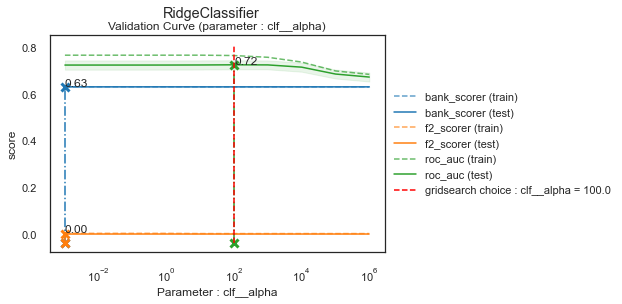

In [68]:
plot_best_param_scores(gs, param='clf__alpha', scorers=CV_SCORERS,
                       model_name='RidgeClassifier', filter_other_params=False)


10
best_param 100.0
"RidgeClassifier_-_Validation_Curve_(parameter_-_clf__alpha)_(scorer_=_bank_scorer).png"


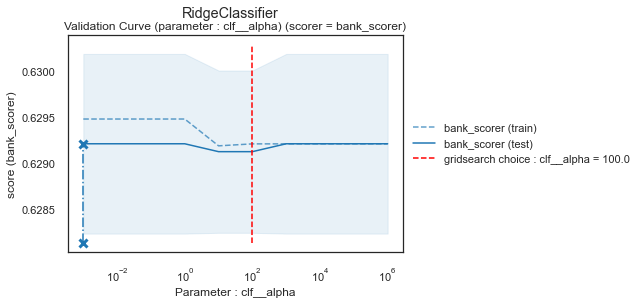

In [69]:

plot_best_param_scores(
    gs, param='clf__alpha', scorers='bank_scorer', model_name='RidgeClassifier', filter_other_params=False)


### Time model

On ne mesure pas le temp pour le GridSearchCV, car ça dépend du nombre de choix d'hyperparamètres pour chaque modèle

On mesure le temp d'entrainement d'un modèle avec des paramètres choisis


## Trouve le meilleur modèle avec GridSearch

### Choix de scorer pour GridSearch


In [70]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


def search_best_model(model_name, estimator_, param_grid_,
                      x_train_, y_train_,
                      scoring_=CV_SCORERS,
                      refit_scorer='roc_auc',
                      return_train_score=False,
                      plot_param_grid_curves=False,
                      randomized_search=False,
                      n_iter=10
                      ):
    if randomized_search:
        # if grid search is long
        searchtype = 'RandomizedSearchCV'
        gs_ = RandomizedSearchCV(
            estimator=estimator_,
            param_distributions=param_grid,
            n_iter=n_iter,
            verbose=1,
            scoring=scoring_,
            refit=refit_scorer,
            return_train_score=return_train_score
        )
    else:
        searchtype = 'GridSearchCV'
        gs_ = GridSearchCV(
            estimator=estimator_,
            param_grid=param_grid_,
            cv=5, n_jobs=-1,
            verbose=1,
            scoring=scoring_,
            refit=refit_scorer,
            return_train_score=return_train_score)

    # lance le gridsearch
    start = get_time()
    gs_.fit(x_train_, y_train_)
    end = get_time()

    cv_time = round(end-start, 3)
    print(f'{searchtype} took {cv_time} s')

    # plot param_grid curves (verification que les best_params sont trouvés)
    if plot_param_grid_curves:
        for param in gs_.best_params_:
            print(f'param : {param}')
            plot_best_param_scores(
                gs_, param, model_name, scorers=refit_scorer)
            plt.show()

    return gs_


{'alpha': 1.0, 'class_weight': None, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
GridSearchCV took 1.188 s
param : clf__alpha
10
best_param 0.05994842503189409
(10, 30)
"Test_model_-_Validation_Curve_(parameter_-_clf__alpha)_(scorer_=_roc_auc).png"


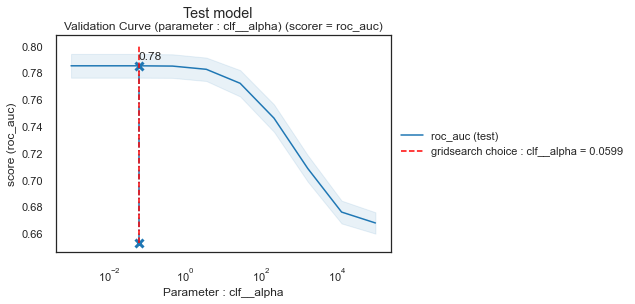

{'clf__alpha': 0.05994842503189409}


In [71]:
# Test
from sklearn.linear_model import RidgeClassifier
print(RidgeClassifier().get_params())

param_grid = {
    # 'clf__class_weight': [None,'balanced'],
    'clf__alpha': np.logspace(-3, 5, 10)
},

gs = search_best_model('Test model', test_model,
                       param_grid, x_sample, y_sample,
                       refit_scorer='roc_auc',
                       plot_param_grid_curves=True)
print(gs.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomizedSearchCV took 1.971 s
param : clf__alpha
10
best_param 0.05994842503189409
(10, 30)
"Test_model_-_Validation_Curve_(parameter_-_clf__alpha)_(scorer_=_roc_auc).png"


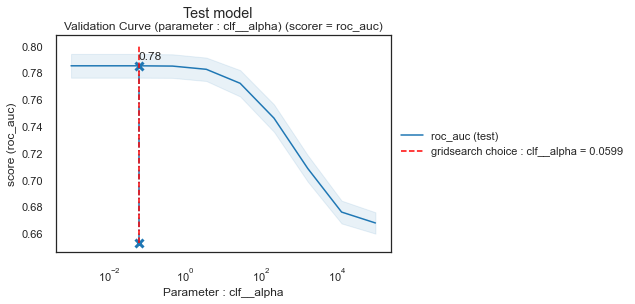

{'clf__alpha': 0.05994842503189409}


In [72]:
gs = search_best_model('Test model', test_model,
                       param_grid, x_sample, y_sample,
                       refit_scorer='roc_auc',
                       randomized_search=True,
                       plot_param_grid_curves=True,
                       )
print(gs.best_params_)


## Propriétés du best modèle


#### Get estimator

Chaque pipeline contient des regressors dans des positions différents:

- (estimator) - l'estimator est à la racine
  - `gs.best_estimator_`
- (clf, estimator) - l'estimator est un named step 'clf'
  - `gs.best_estimator_.named_steps['clf']`
- (clf, TransformedTargetClassifier(clf=estimator))
  - `gs.best_estimator_.named_steps['clf'].regressor_`

Pour éviter des erreurs en changeant le pipeline, voici quelques utilitaires pour retourner l'estimateur, son classname, les attributs, les feature*importances*, etc


In [73]:
def get_classifier(model):
    """Trouver le classifier dans un pipeline"""
    if hasattr(model, 'coefs_') or hasattr(model, 'intercept_'):
        return model
    if hasattr(model, 'feature_importances_'):
        return model
    if hasattr(model, 'estimators_'):
        return model

    if hasattr(model, 'regressor_'):
        return get_classifier(model.regressor_)

    if hasattr(model, 'named_steps'):
        try:
            clf = model.named_steps['clf']
        except:
            clf = None
        if not clf is None:
            return get_classifier(clf)

    if hasattr(model, 'clf'):
        return get_classifier(model.clf)

    if isinstance(model, BaseEstimator):
        # if hasattr(model, 'coef_') or hasattr(model, 'feature_importances_'):
        return model
    else:
        return 'classifier not found'


# test 1
get_classifier(test_model)


RidgeClassifier()

In [74]:
# test 2
get_classifier(RidgeClassifier())


RidgeClassifier()

In [75]:
# test 3
get_classifier(gs.best_estimator_)


RidgeClassifier(alpha=0.05994842503189409)

In [76]:

def get_classname(estimator):
    return estimator.__class__.__name__


def get_model_classname(model):
    estimator = get_classifier(model)
    return get_classname(estimator)


def get_model_feature_importances(model):
    estimator = get_classifier(model)
    return getattr(estimator, 'feature_importances_', None)


def get_model_estimators(model):
    estimator = get_classifier(model)
    return getattr(estimator, 'estimators_', None)


In [77]:
def filtered_list(values, mask):
    res = [i for (i, v) in zip(values, mask) if v]
    return res


def get_step(model, step_name='k_best'):
    if hasattr(model, 'named_steps'):
        try:
            step = model.named_steps[step_name]
        except:
            step = None
        return step
    name = get_classname(model)
    if name == step_name:
        return model
    return None


def get_kbest_features(model, features_in=None):
    """cv.best_estimator_.named_steps['k_best'].get_support()"""
    k_best = get_step(model, 'k_best')
    if not k_best is None:
        if hasattr(k_best, 'get_support'):
            mask = k_best.get_support()
            if len(mask) == len(features_in):
                return filtered_list(features_in, mask)
    return None


### Propriétés du best classifier


In [78]:
def get_classifier_attributs(gs, public_only=True):
    model = get_classifier(gs.best_estimator_)
    attributs = dir(model)
    if public_only:
        attributs = [a for a in attributs if not a.startswith('_')]
    print(attributs)


get_classifier_attributs(gs)


['alpha', 'class_weight', 'classes_', 'coef_', 'copy_X', 'decision_function', 'feature_names_in_', 'fit', 'fit_intercept', 'get_params', 'intercept_', 'max_iter', 'n_features_in_', 'n_iter_', 'normalize', 'positive', 'predict', 'random_state', 'score', 'set_params', 'solver', 'tol']


## Fonctions pour comparaison des models (score, temps, params)


### Add Model Score (df_scores)

Le score du model est composé de:

- paramêtres (nom de model(algorithme/dataset), best_params)
- gridsearch scores (train/test) sur x_train, y_train
- validation performance metrics sur x_test, y_test

Les temps total de gridsearch, plus le temps d'entrainement du model avec best_params sont aussi enregistrés


In [79]:
from sklearn.base import BaseEstimator
metrics_columns = list(performance_metrics(y_true1, y_pred1).keys())
cols = ['model_name', 'params', 'train_time',
        'gridsearch_time'] + metrics_columns

df_scores = pd.DataFrame(columns=cols)


def add_model_score(model_name: str,
                    model: BaseEstimator,
                    train_time, gridsearch_time,
                    params: dict,
                    scores: dict,
                    metrics: dict):
    """Ajouter les resultats de gridsearch sur xtrain,ytrain et score sur xtest,ytest aux scores"""

    global df_scores
    print(f'add_model_score, model = {model_name}')

    # identification du model
    model_keys = dict(
        model_name=model_name,
        model=model,
    )

    # params contient gridsearch.best_params_
    gridsearch_results = dict(
        params=params,
        gridsearch_time=gridsearch_time,
        train_time=train_time,
    )
    # validation scores sont dans metrics

    row = dict(**model_keys, **scores, **gridsearch_results, **metrics)

    df_scores = df_scores.append(row, ignore_index=True)
    return df_scores


### Validation (score) d'un model

#### Récupérer les paramêtres / scores de GridSearch et prédire sur le jeu de données "test"


In [80]:
from sklearn.utils.extmath import softmax
from sklearn.utils.validation import check_is_fitted
def predict_proba(fitted_model: BaseEstimator, x_test_):
    """
    Predict probabilities of x_test

    Parameters
    ----------  
    fitted_model : gridsearch.best_estimator_ or any classifier. 
                   If gridsearch(estimator) is a pipeline, best_estimator_ is this pipeline 
    x_test_ : the x values to predict
    
    Returns
    -------
    The probabilities of X for each class in target
    """

    def predict_proba_from_decision_function(clf, x_):
        """
        RidgeClassifier has no predict_proba
        https://stackoverflow.com/a/22538080/
        """
        d = clf.decision_function(x_)
        d_2d = np.c_[-d, d]
        return softmax(d_2d)

    try:
        y_pred_proba_ = fitted_model.predict_proba(x_test_)
    except:
        # classifier does not implement predict_proba, use decision_function (ex. RidgeClassifier)
        y_pred_proba_ = predict_proba_from_decision_function(fitted_model, x_test_)
    return y_pred_proba_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomizedSearchCV took 3.095 s
param : clf__alpha
10
best_param 0.05994842503189409
(10, 51)
"Test_model_-_Validation_Curve_(parameter_-_clf__alpha)_(scorer_=_roc_auc).png"


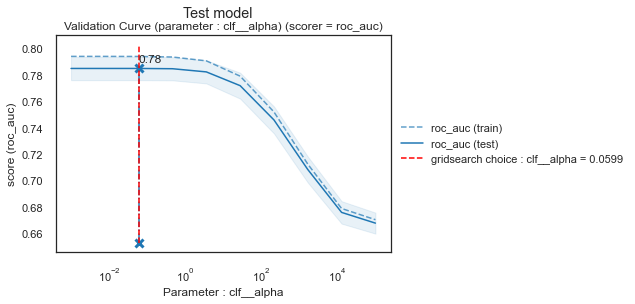

{'clf__alpha': 0.05994842503189409}
Best Parameters: {'clf__alpha': 0.05994842503189409}
Best Train Score (roc_auc) : 0.794
Best Test Score (roc_auc): 0.785
bestmodel type =  <class 'sklearn.pipeline.Pipeline'>
time_model (test_model; training time = 0.027 s; estimated gridsearch time (50 splits) = 1.95 s
add_model_score, model = test_model


In [81]:
# from sklearn.model_selection import cross_validate


def score_model(model_name, gs_,
                x_train_, y_train_, x_test_, y_test_,
             score='roc_auc', threshold_=0.5, verbose=True) -> npt.ArrayLike:
    """
    Après grid search, récuperer le best model, fit sur train et score sur test, enregistre dans df_scores
    
    
    Returns
    --------
    predicted values (y_pred) for x_test
    """
    global df_scores
    best_model = gs_.best_estimator_
    best_params = gs_.best_params_  # gs.cv_results_["params"][gs.best_index_]

    cv = pd.DataFrame(gs_.cv_results_)

    # get scores
    scores = dict(
        best_cv_score=getattr(gs_, 'best_score_', np.NaN),  # mean_test_score
        refit_time=getattr(gs_, 'refit_time_', np.NaN),  # train_time
    )
    scorer_keys = get_scorers(cv)
    for scorer in scorer_keys:
        # gs.best_score_
        scores[f'mean_test_{scorer}'] = cv[f'mean_test_{scorer}'][gs_.best_index_].mean(
        )
        scores[f'std_test_{scorer}'] = cv[f'std_test_{scorer}'][gs_.best_index_].mean(
        )

        if f'mean_train_{scorer}' in cv.columns:
            # gridsearch with return_train_scores=True
            # helps measure bias and variance, but computationally expensive to keep measuring
            scores[f'mean_train_{scorer}'] = cv[f'mean_train_{scorer}'][gs_.best_index_].mean(
            )
            scores[f'std_train_{scorer}'] = cv[f'std_train_{scorer}'][gs_.best_index_].mean(
            )

    for key in scores.keys():
        scores[key] = round_digits(scores[key], 3)

    mean_fit_time = round_digits(cv[f'mean_fit_time'].mean())
    mean_score_time = round_digits(cv[f'mean_score_time'].mean())
    fit_time = len(cv)*mean_fit_time

    n_folds = gs_.n_splits_  # number of splits of training data
    n_iter = len(cv)  # Iterations per split
    gridsearch_time = round(
        (mean_fit_time + mean_score_time)*n_folds * n_iter, 3)
    if verbose:
        # print(f'Best Estimator: {best_model}')
        print(f'Best Parameters: {best_params}')
        if f'mean_train_{score}' in cv.columns:
            print(
                f'Best Train Score ({score}) : {scores[f"mean_train_{score}"]:.3f}')
        if f'mean_test_{score}' in cv.columns:
            print(
                f'Best Test Score ({score}): {scores[f"mean_test_{score}"]:.3f}')

    start = get_time()
    best_model = gs_.best_estimator_
    best_model.fit(x_train_, y_train_)
    end = get_time()
    train_time = round(end-start, 3)

    y_pred_proba_ = predict_proba(best_model, x_test_)[:,1]
    y_pred_= (y_pred_proba_ > threshold_)*1

    
    if verbose:
        print('bestmodel type = ', type(best_model))

    print(
        f'time_model ({model_name}; training time = {mean_fit_time} s; estimated gridsearch time ({(n_folds*n_iter)} splits) = {gridsearch_time} s')

    # only run performance metrics on best model
    dict_metrics = performance_metrics(y_test_, y_pred_)

    dict_metrics['discrimination_threshold'] = threshold_
    add_model_score(model_name=model_name,
                    model=best_model,
                    train_time=train_time,
                    gridsearch_time=gridsearch_time,
                    params=best_params,
                    scores=scores,
                    metrics=dict_metrics,
                    )
    return y_pred_proba_


gs = search_best_model('Test model', test_model,
                       param_grid, x_sample, y_sample,
                       refit_scorer='roc_auc',
                       return_train_score=True,
                       randomized_search=True,
                       plot_param_grid_curves=True,
                       )
print(gs.best_params_)
y_pred_proba = score_model('test_model', gs, x_sample,
                     y_sample, x_test_prep, y_test)


### Test score model


In [82]:
model_name = 'RidgeClassifier'

# Pipeline pour les données non-processés (x_train,y_train) à l'entrée:
# model_pipeline = imbpipeline.Pipeline([
#     ('preprocess', numeric_pipeline),
#     ('sampling', SMOTE(random_state= RANDOM_SEED)),
#     ('clf', RidgeClassifier())])

model_pipeline = Pipeline([('clf', RidgeClassifier())])
x_train_smote, y_train_smote = SMOTE(
    random_state=RANDOM_SEED).fit_resample(x_train_prep, y_train)
param_grid = {'clf__alpha': np.logspace(-3, 5, 20)}
gs = search_best_model(model_name, model_pipeline,
                       param_grid,
                       x_train_smote, y_train_smote)
y_pred_proba = score_model(model_name, gs,
                     x_train_smote, y_train_smote,
                     x_test_prep, y_test)
                     

Fitting 5 folds for each of 20 candidates, totalling 100 fits
GridSearchCV took 8.048 s
Best Parameters: {'clf__alpha': 6.158482110660261}
Best Test Score (roc_auc): 0.786
bestmodel type =  <class 'sklearn.pipeline.Pipeline'>
time_model (RidgeClassifier; training time = 0.069 s; estimated gridsearch time (100 splits) = 8.7 s
add_model_score, model = RidgeClassifier


## Effet de changer le threshold sur les scores

Le model est optimiser pour maximiser le Area Under the Curve, sur la supposition que le threshold = 0.5

- <https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/>

In [83]:
def calc_threshold_scores(y_pred_proba, thresholds= np.linspace(0.1, 0.9, 17)):
    """Score model for different thresholds"""
    df_thresh=pd.DataFrame()
    for thresh in thresholds:
        y_pred=(y_pred_proba>thresh)*1
        metr=performance_metrics(y_test, y_pred)
        res=dict(discrimination_threshold=thresh)
        res=dict(**res,**metr)
        df_thresh=df_thresh.append(res, ignore_index=True)
    return df_thresh

df_thresh=calc_threshold_scores(y_pred_proba)
df_thresh.head()

discrimination_threshold  logloss  precision  recall    f05     f1     f2  \
0                      0.10   30.844      0.081   0.994  0.100  0.150  0.306   
1                      0.15   28.996      0.086   0.987  0.105  0.158  0.318   
2                      0.20   26.388      0.092   0.969  0.112  0.168  0.333   
3                      0.25   23.711      0.099   0.943  0.121  0.179  0.349   
4                      0.30   20.810      0.105   0.874  0.127  0.187  0.355   

      f5  bank_scorer  roc_auc  
0  0.694        0.387    0.512  
1  0.703        0.421    0.538  
2  0.708        0.467    0.571  
3  0.711        0.512    0.601  
4  0.682        0.548    0.615

In [84]:
def find_best_threshold(df_thresh_:pd.DataFrame,scorer='roc_auc'):
    max_score=df_thresh_[scorer].max()
    idx=df_thresh_[scorer].argmax()
    best_threshold=df_thresh_['discrimination_threshold'][idx]
    return best_threshold, max_score

for scorer in ['roc_auc','f2','bank_scorer']:
    best_thresh, max_score=find_best_threshold(df_thresh, scorer)
    print(f'best threshold for {scorer} : {best_thresh:.3f} (score = {max_score:.3f})')

best threshold for roc_auc : 0.450 (score = 0.659)
best threshold for f2 : 0.450 (score = 0.384)
best threshold for bank_scorer : 0.700 (score = 0.694)


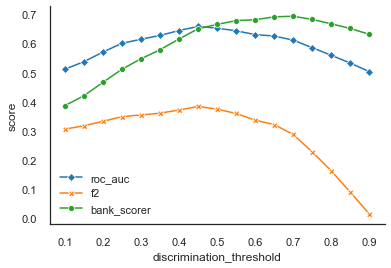

In [85]:

def plot_threshold_scores(y_pred_proba, scorers=['roc_auc','f2','bank_scorer'], ax=None):
    df_thresh= calc_threshold_scores(y_pred_proba)
    if isinstance(scorers, str):
        scorers = [scorers]
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    colors=sns.color_palette('tab10')
    markers=['D','X','o','^','s','+']
    for i,scorer in enumerate(scorers):
        sns.lineplot(df_thresh['discrimination_threshold'],
                    df_thresh[scorer], marker=markers[i], color=colors[i], label=scorer,ax=ax)
    ax.legend(loc='best')
    ylabel='score' if len(scorers) > 1 else f'score ({scorers[0]})'
    ax.set_ylabel(ylabel)
    sns.despine()


plot_threshold_scores(y_pred_proba)

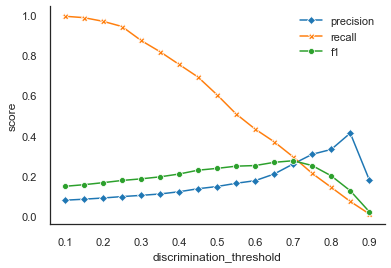

In [86]:
plot_threshold_scores(y_pred_proba, ['precision','recall','f1'])


## Visualisations


## Confusion matrix, ROC Curve et Precision-Recall Curves


### Confusion Matrix


              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1841
           1       0.26      0.30      0.28       159

    accuracy                           0.88      2000
   macro avg       0.60      0.61      0.61      2000
weighted avg       0.88      0.88      0.88      2000



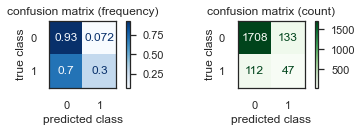

In [87]:
Serie = list or np.ndarray or pd.Series


def plot_confusion_matrix_heatmap(y_true_: Serie, y_pred_: Serie,
                                  normalize=True, cmap='Blues', ax=None, figsize=(3, 2)):
    """<
    plot confusion matrix as heatmap

    Parameters
    ----------
    y_true : labels (number or string list, 1-d array or series)
    y_pred : labels (number or string list, 1-d array or series)
    cmap: colors
    figsize: figure size
    """
    # df_cm = confusion_matrix_crosstab(y_true, y_pred, normalize=normalize)

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    if normalize == True or normalize == 'true':
        # df_cm = metrics.confusion_matrix(y_true_, y_pred_, normalize='true')
        # sns.heatmap(df_cm, annot=True, cmap=cmap, fmt='.2f', ax=ax)
        metrics.ConfusionMatrixDisplay.from_predictions(
            y_true_, y_pred_, normalize='true', cmap='Blues', ax=ax)
        ax.set_title('confusion matrix (frequency)')
    else:
        # df_cm = metrics.confusion_matrix(y_true_, y_pred_)
        # sns.heatmap(df_cm, annot=True, cmap=cmap, fmt='.0f',ax=ax)
        metrics.ConfusionMatrixDisplay.from_predictions(
            y_true_, y_pred_, cmap='Greens', ax=ax)
        ax.set_title('confusion matrix (count)')

    ax.set_xlabel('predicted class')
    ax.set_ylabel('true class')
    ax.grid(False)
    plt.tight_layout(h_pad=0.2, w_pad=0.2)

y_pred=(y_pred_proba>0.7)*1

_, axs = plt.subplots(1, 2, figsize=(6, 2))
plot_confusion_matrix_heatmap(y_test, y_pred, True, ax=axs[0])
plot_confusion_matrix_heatmap(y_test, y_pred, False, ax=axs[1])
print(metrics.classification_report(y_test, y_pred))


On note que les valeurs dans la diagonale de la matrice de confusion sont les valeurs de 'recall' dans le classification report


### ROC (Receiver Operating Characteristic)

Un ROC Curve montre le **sensitivity (ou recall)** versus (1 - **specificity**)

- True Positive Rate (TPR) = sensitivity = TP / (TP + FN)

- False Positive Rate (FPR) = 1 - specificity = TN / (TN + FP)

### References

- <https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics>


### AUC (Area Under the Curve)

On cherche les courbes la plus proche de coin en haut à gauche (recall = 1, moins de faux positifs possibles)

Donc on essaie de maximiser le Area Under the Curve


threshold = 0.25, recall for label 1 (TPR) = 0.943
threshold = 0.5, recall for label 1 (TPR) = 0.604
threshold = 0.75, recall for label 1 (TPR) = 0.214


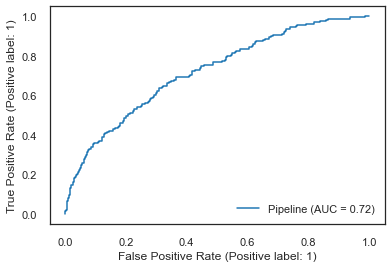

In [88]:
def plot_roc_from_clf(clf: BaseEstimator, x_test_, y_test_, **kwargs):
    display = metrics.RocCurveDisplay.from_estimator(
        clf, x_test_, y_test_, **kwargs)
    for threshold in [0.25,0.5,0.75]:
        y_pred_proba_ = predict_proba(clf,x_test_)[:,1]
        y_pred_=(y_pred_proba_>threshold)*1
        recall = metrics.recall_score(y_test_, y_pred_)
        print(f'threshold = {threshold}, recall for label 1 (TPR) = {recall:.3f}')


model_pipeline.set_params(**dict(gs.best_params_))
model_pipeline.fit(x_train_smote, y_train_smote)
plot_roc_from_clf(model_pipeline, x_test_prep, y_test)



### Precision- Recall Curve pour TARGET==1

Un autre façon de visualiser est avec la courbe de precision - recall

- Precision = TP/(TP + FP) : Quelle portion du cluster prédit sont du vrai classe ?
- Recall = TP/(TP + FN) : Quelle portion du vrai classe sont présent dans le cluster prédit ?


## Results Summary pour un model

On met ensemble les résultats

On affiche le geometric mean 
- https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

Plotting results for RidgeClassifier with best_params : {'clf__alpha': 6.158482110660261}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1841
           1       0.15      0.60      0.24       159

    accuracy                           0.69      2000
   macro avg       0.55      0.65      0.52      2000
weighted avg       0.89      0.69      0.76      2000

1-specificity(FPR) = 0.30, sensitivity(TPR) 0.60
best threshold for roc_auc : 0.450 (score = 0.659)
best threshold for f2 : 0.450 (score = 0.384)
best threshold for bank_scorer : 0.700 (score = 0.694)
Best Threshold=0.455, Youden J =0.327
Best Threshold=0.696, F-Score=0.291
"RidgeClassifier_-_Summary-_best_params={'clf__alpha'-_6-16}.png"


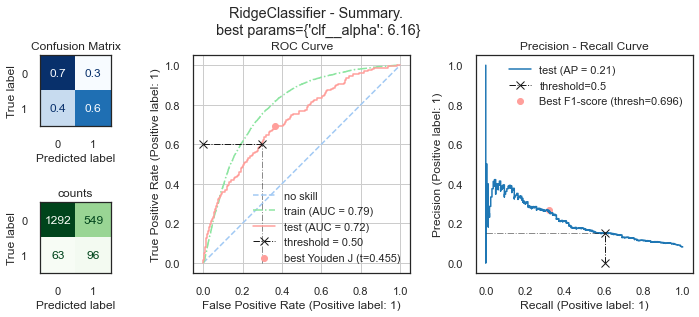

In [89]:
# from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

def plot_cm_roc(model_pipeline_: BaseEstimator, gs_, x_train_, y_train_, x_test_, y_test_, 
    y_pred_proba_=None,threshold_=0.5, 
    model_name=None, titre=None):
    """
    plot confusion matrix, ROC and precision-recall curves
    model_pipeline can be a classifier or a pipeline with a classifier
    """
    # print(x_train_.shape,y_train_.shape,x_test_.shape, y_test.shape)

    if model_name is None:
        model_name = get_model_classname(model_pipeline_)
    best_params = gs_.best_params_
    print(
        f'Plotting results for {model_name} with best_params : {gs_.best_params_}')

    # ----- Recover best model (needed for plotting ROC / Precision-Recall curves from estimator)
    # plotting ROC from predictions gives underestimate of AUC - too few points
    try:
        best_model = gs_.best_estimator_
    except:
        model_pipeline_.set_params(**dict(gs_.best_params_))
        best_model = model_pipeline_

    # ensure model is fitted
    best_model.fit(x_train_, y_train_)

    # ------- Calculate probabilities of True Positive, if not already calculated
    if y_pred_proba_ is None:        
        y_pred_proba_=predict_proba(best_model, x_test_)[:,1]
    
    y_pred_ = (y_pred_proba_ > threshold_)*1
    
    # --------Classification Report -------------------

    print(f'Classification_report (threshold={threshold_:.3f}):')
    print(metrics.classification_report(y_test_,y_pred_))

    # ----------Extract recall and precision for chosen threshold
    (TN, FP, FN, TP) = metrics.confusion_matrix(y_test_, y_pred_).ravel()
    TPR = TP/(TP+FN)
    FPR = 1 - TN / (TN + FP)
    recall = TPR
    precision = TP/(TP+FP)
    # recall=metrics.recall_score(y_test_, y_pred_)
    print(f'1-specificity(FPR) = {FPR:.2f}, sensitivity(TPR) {TPR:.2f}')

    # --------- Best thresholds ----------------------
    df_thresh = calc_threshold_scores(y_pred_proba_)
    for scorer in ['roc_auc','f2','bank_scorer']:
        best_thresh, max_score=find_best_threshold(df_thresh, scorer)
        print(f'best threshold for {scorer} : {best_thresh:.3f} (score = {max_score:.3f})')
    
    # Initialise plots
    nb = 13  # keep gridspec square
    fig, _ = plt.subplots(figsize=(nb, 4))
    gridspec = fig.add_gridspec(12, nb)

    # ----------Plot Confusion matrices 
    ax = plt.subplot(gridspec[:4, :4])
    # metrics.ConfusionMatrixDisplay.from_estimator(model_pipeline_, x_test_, pd.Series(y_test_),normalize='true',cmap='Blues',ax=ax)
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test_, y_pred_, normalize='true', cmap='Blues', ax=ax, colorbar=False)
    ax.grid(False)
    plt.title('Confusion Matrix')

    ax = plt.subplot(gridspec[8:12, :4])
    # metrics.ConfusionMatrixDisplay.from_estimator(model_pipeline_, x_test_, pd.Series(y_test_),normalize='true',cmap='Blues',ax=ax)
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test_, y_pred_, normalize=None, cmap='Greens', ax=ax, colorbar=False)
    plt.title('counts')
    ax.grid(False)

    # -------- Plot ROC Curves ------

    ax = plt.subplot(gridspec[:, 4:8])
    ax.plot([0, 1], [0, 1], color='b', ls='--', label='no skill')
    metrics.RocCurveDisplay.from_estimator(
        best_model, x_train_, y_train_, name='train', c='g', ls='-.', ax=ax)
    metrics.RocCurveDisplay.from_estimator(
        best_model, x_test_, y_test_, name='test', c='r', ax=ax)

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([FPR]*2, [0, TPR], linestyle="-.", color='k', alpha=0.5, lw=1)
    ax.plot([0, FPR], [TPR]*2, color='k', ls='-.', lw=1, marker="x", markeredgewidth=1, ms=8,
            label=f'threshold = {threshold_:.2f}')


    # predict probabilities
    # yhat = best_model.predict_proba(x_test_)
    # keep probabilities for the positive outcome only
    # yhat = yhat[:, 1]
    yhat=y_pred_proba_
    # calculate roc curves
    fpr, tpr, thresholds = metrics.roc_curve(y_test_, yhat)

    # Best geometric mean
    # calculate the g-mean for each threshold
    # gmeans = np.sqrt(tpr * (1-fpr))
    # # locate the index of the largest g-mean
    # ix = np.argmax(gmeans)
    # print (f'ix 1 = {ix}')
    # print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    # print(f'Best Threshold={thresholds[ix]:.3f}, G-mean ={gmeans[ix]:.3f}')
    #
    # get the best threshold using Youden’s J statistic.
    # geometric mean of 
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print(f'Best Threshold={thresholds[ix]:.3f}, Youden J ={J[ix]:.3f}')
    # plot the roc curve for the model
    ax.scatter(fpr[ix], tpr[ix], marker='o', color='r', label=f'best Youden J (t={thresholds[ix]:.3f})')

    ax.grid(True)
    ax.legend(loc='best')
    plt.title('ROC Curve')


    # -------- Plot Precision Recall curves

    ax = plt.subplot(gridspec[:, 9:])
    metrics.PrecisionRecallDisplay.from_estimator(
        best_model, x_test_, y_test_, name='test', ax=ax)
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([0, recall], [precision]*2,
            linestyle="-.", color='k', alpha=0.5, lw=1)
    ax.plot([recall]*2, [0, precision], color='k', ls='-.', marker="x",
            markeredgewidth=1, lw=1, ms=8, label='threshold=0.5')
    
    precision, recall, thresholds = metrics.precision_recall_curve(y_test_, yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall+1e-6)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}')
    ax.scatter(recall[ix], precision[ix], marker='o', color='r', label=f'Best F1-score (thresh={thresholds[ix]:.3f})')

    ax.legend(loc='best')
    ax.grid(False)
    plt.title('Precision - Recall Curve')

    for key in best_params.keys():
        best_params[key] = round_digits(best_params[key], 3)
    if titre is None:
        titre = f'{model_name} - Summary. \nbest params={best_params}'
    plt.suptitle(titre, y=1.05)
    to_png()


plot_cm_roc(model_pipeline, gs,
            x_train_smote, y_train_smote,
            x_test_prep, y_test)


# Reset data and Cleanup

In [90]:
# vider le score des tests
df_scores = df_scores.drop(df_scores.index)

# 1. Create X, y from dataframe
X, y = create_X_y(df_data)


# 2. Split data
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
# x_train_sample, x_test_sample, y_train_sample, y_test_sample = train_test_split(
#     x_sample, y_sample, test_size=0.2, stratify=y, random_state=RANDOM_SEED)


# # 3. Preprocess data (impute, optionally rescale)
# # set 1 - sans ré-equilibrage
# x_train_prep, x_test_prep = preprocess(numeric_pipeline, x_train, x_test)

# # subsample (size= 10000) without re-balancing - for testing pipelines / visualisation
# x_train_sample, x_test_sample = preprocess(
#     numeric_pipeline, x_train_sample, x_test_sample)

# # 4. Sample data
# # Note: sample only training dataset; the test dataset remains imbalanced

# # Set 2 - random undersample
# x_train_under, y_train_under = undersampler.fit_resample(x_train_prep, y_train)

# # Set 3 - random oversample
# x_train_over, y_train_over = oversampler.fit_resample(x_train_prep, y_train)

# # Set 4 - SMOTE oversample minority class
# x_train_smote, y_train_smote = smote_auto.fit_resample(x_train_prep, y_train)

# # Set 5 - SMOTE_Tomek
# x_train_tomek, y_train_tomek = smote_tomek.fit_resample(x_train_prep, y_train)

# # Set 6 - SMOTE ADASYN
# x_train_adasyn, y_train_adasyn = smote_adasyn.fit_resample(
#     x_train_prep, y_train)


# Models

Pour chaque classifier, il faut:

- optimise preprocessing (eviter d'attribuer un moyen nombre d'enfants pour les clients par exemple)
- optimise sampling (under / over sampling)
- optimise feature selection (plus simple si on choisit les models avec embedded feature selection)
- optimise classifier hyperparameters


## Classifiers candidats

Pour ce rapport, on teste les classificateurs suivants:

| Classifier     | Logistic Regression | Random Forest | LightGBM |
| -------------- | :-----------------: | :-----------: | :------: |
| cost-sensitive |         ✔️          |      ✔️       |    ✔️    |
| undersample    |         ✔️          |               |          |
| oversample     |         ✔️          |               |          |
| SMOTE          |         ✔️          |      ✔️       |    ✔️    |
| SMOTE Tomek    |         ✔️          |               |          |
| SMOTE ADASYN   |         ✔️          |      ✔️       |    ✔️    |


In [91]:
def evaluate_model(model_name_, estimator, 
train_x,train_y, 
test_x,test_y, 
param_grid={}, threshold_=0.5):
    # GridSearch
    gs = search_best_model(model_name_, estimator,param_grid, train_x, train_y)
    
    # score best model from grid search
    y_pred_proba_ = score_model(model_name, gs, train_x, train_y,
        test_x, test_y)  
    
    y_pred_=(y_pred_proba_>threshold_)*1
    print(performance_metrics(test_y, y_pred_, y_pred_proba_))

    # Show summary reports for model
    plot_cm_roc(estimator, gs, train_x, train_y,
            test_x, test_y, y_pred_proba_, model_name=model_name_)

## Baseline Classification


In [92]:
model_name = 'Baseline (Dummy)'
param_grid = {}
dummy_pipeline = Pipeline(steps=[
    # ('preprocess', numeric_pipeline),
    # ('sample', )
    # ('feat_select')
    ('clf', DummyClassifier(strategy="stratified"))
])

dummy_pipeline


Pipeline(steps=[('clf', DummyClassifier(strategy='stratified'))])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
GridSearchCV took 0.261 s
Best Parameters: {}
Best Test Score (roc_auc): 0.499
bestmodel type =  <class 'sklearn.pipeline.Pipeline'>
time_model (Baseline (Dummy); training time = 0.013 s; estimated gridsearch time (5 splits) = 0.115 s
add_model_score, model = Baseline (Dummy)
{'logloss': 4.922, 'precision': 0.116, 'recall': 0.119, 'f05': 0.117, 'f1': 0.118, 'f2': 0.119, 'f5': 0.119, 'bank_scorer': 0.625, 'roc_auc': 0.52}
Plotting results for Baseline (Dummy) with best_params : {}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1841
           1       0.12      0.12      0.12       159

    accuracy                           0.86      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.86      0.86      0.86      2000

1-specificity(FPR) = 0.08, sensitivity(TPR) 0.12
best threshold for roc_auc : 0.100 (sco

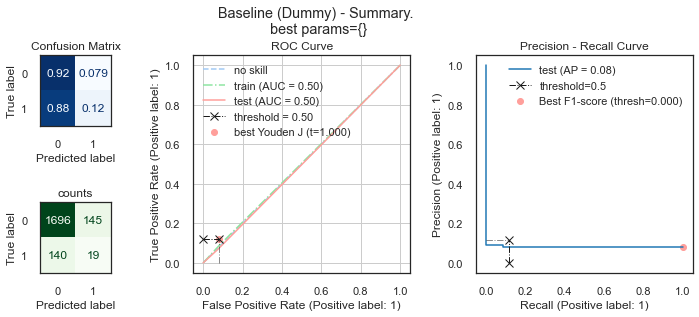

In [93]:
evaluate_model(model_name,dummy_pipeline, x_train_prep, y_train, x_test_prep, y_test)

## RidgeClassifier

### RidgeClassifier (cost-sensitive)

In [94]:
model_name = 'RidgeClassifier (cost-sensitive)'

ridge_pipeline = Pipeline(steps=[
    # ('preprocess', numeric_pipeline),
    # ('sample', )
    # ('feat_select')
    ('clf', RidgeClassifier(class_weight='balanced'))
])

# ridge_pipeline


Fitting 5 folds for each of 1 candidates, totalling 5 fits
GridSearchCV took 0.306 s
Best Parameters: {}
Best Test Score (roc_auc): 0.723
bestmodel type =  <class 'sklearn.pipeline.Pipeline'>
time_model (RidgeClassifier (cost-sensitive); training time = 0.038 s; estimated gridsearch time (5 splits) = 0.27 s
add_model_score, model = RidgeClassifier (cost-sensitive)
{'logloss': 10.396, 'precision': 0.152, 'recall': 0.61, 'f05': 0.179, 'f1': 0.244, 'f2': 0.381, 'f5': 0.547, 'bank_scorer': 0.671, 'roc_auc': 0.726}
Plotting results for RidgeClassifier (cost-sensitive) with best_params : {}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.95      0.71      0.81      1841
           1       0.15      0.61      0.24       159

    accuracy                           0.70      2000
   macro avg       0.55      0.66      0.53      2000
weighted avg       0.89      0.70      0.77      2000

1-specificity(FPR) = 0.29, sensitivity(T

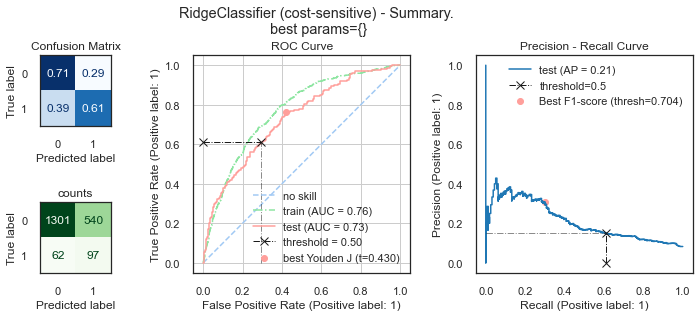

In [95]:
param_grid = {
    'clf__alpha': np.logspace(-3, 3, 7)
}
evaluate_model(model_name,ridge_pipeline, x_train_prep, y_train, x_test_prep, y_test)


### RidgeClassifier (bordeline SMOTE)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV took 3.262 s
Best Parameters: {'clf__alpha': 10.0}
Best Test Score (roc_auc): 0.830
bestmodel type =  <class 'sklearn.pipeline.Pipeline'>
time_model (RidgeClassifier (borderline SMOTE); training time = 0.079 s; estimated gridsearch time (35 splits) = 3.5 s
add_model_score, model = RidgeClassifier (borderline SMOTE)
{'logloss': 9.291, 'precision': 0.166, 'recall': 0.591, 'f05': 0.194, 'f1': 0.259, 'f2': 0.391, 'f5': 0.538, 'bank_scorer': 0.687, 'roc_auc': 0.719}
Plotting results for RidgeClassifier (borderline SMOTE) with best_params : {'clf__alpha': 10.0}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.95      0.74      0.84      1841
           1       0.17      0.59      0.26       159

    accuracy                           0.73      2000
   macro avg       0.56      0.67      0.55      2000
weighted avg       0.89      0.73      0.79      200

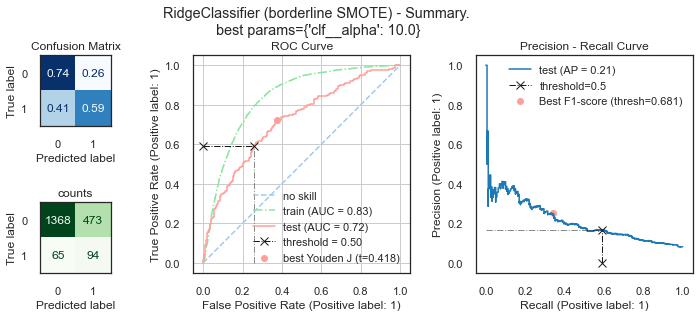

In [96]:
model_name = 'RidgeClassifier (borderline SMOTE)'
smote_border = BorderlineSMOTE(random_state=RANDOM_SEED)
x_train_border, y_train_border = smote_border.fit_resample(
    x_train_prep, y_train)

ridge_pipeline = Pipeline(steps=[
    ('clf', RidgeClassifier(class_weight='balanced'))
])

param_grid = {
    'clf__alpha': np.logspace(-3, 3, 7)
}
evaluate_model(model_name, ridge_pipeline, x_train_border, y_train_border,
            x_test_prep, y_test, param_grid)

In [97]:
# cleanup

del x_train_border, y_train_border

## Logistic Regression 


In [98]:
print(LogisticRegression().get_params())


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### Logistic Regression avec cost-sensitive weights

Fitting 5 folds for each of 2 candidates, totalling 10 fits
GridSearchCV took 0.389 s
Best Parameters: {'clf__class_weight': 'balanced'}
Best Test Score (roc_auc): 0.723
bestmodel type =  <class 'sklearn.pipeline.Pipeline'>
time_model (Logistic Regression (cost-sensitive); training time = 0.042 s; estimated gridsearch time (10 splits) = 0.62 s
add_model_score, model = Logistic Regression (cost-sensitive)
{'logloss': 10.396, 'precision': 0.152, 'recall': 0.61, 'f05': 0.179, 'f1': 0.244, 'f2': 0.381, 'f5': 0.547, 'bank_scorer': 0.671, 'roc_auc': 0.726}
Plotting results for Logistic Regression (cost-sensitive) with best_params : {'clf__class_weight': 'balanced'}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.95      0.71      0.81      1841
           1       0.15      0.61      0.24       159

    accuracy                           0.70      2000
   macro avg       0.55      0.66      0.53      2000
weighted avg       

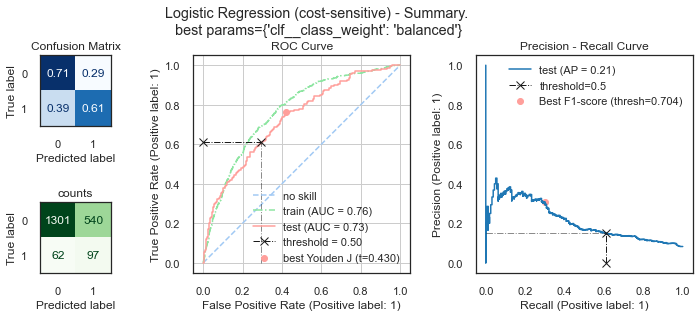

In [99]:
model_name = 'Logistic Regression (cost-sensitive)'
lr_pipeline = Pipeline(steps=[
    # ('preprocess', numeric_pipeline),
    # ('sampling', 'passthrough'),
    # ('feat_select', 'passthrough'),
    ('clf', LogisticRegression()),
])

param_grid = {
    'clf__class_weight': [None, 'balanced'],
    # 'clf__penalty':['l1','l2'],
    # 'clf__solver':['liblinear']
}
evaluate_model(model_name, ridge_pipeline, x_train_prep, y_train,
            x_test_prep, y_test, param_grid)


### Logistic Regression Undersampling


Fitting 5 folds for each of 1 candidates, totalling 5 fits
GridSearchCV took 0.309 s
Best Parameters: {'clf__class_weight': None}
Best Test Score (roc_auc): 0.697
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (Logistic Regression (undersampling); training time = 0.079 s; estimated gridsearch time (5 splits) = 0.45 s
add_model_score, model = Logistic Regression (undersampling)
{'logloss': 11.053, 'precision': 0.148, 'recall': 0.635, 'f05': 0.175, 'f1': 0.24, 'f2': 0.383, 'f5': 0.564, 'bank_scorer': 0.666, 'roc_auc': 0.713}
Plotting results for Logistic Regression (undersampling) with best_params : {'clf__class_weight': None}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1841
           1       0.15      0.64      0.24       159

    accuracy                           0.68      2000
   macro avg       0.55      0.66      0.52      2000
weighted avg       0.89      0.68  

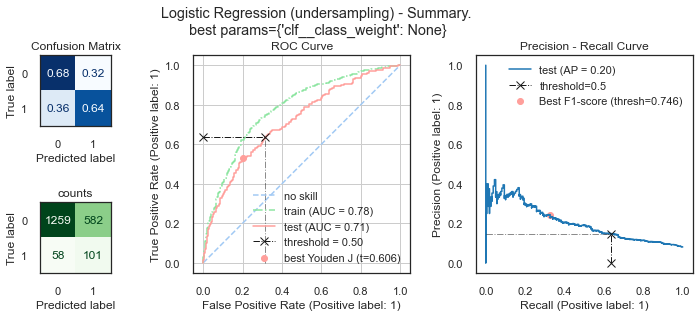

In [100]:
# Random undersampling
model_name = 'Logistic Regression (undersampling)'
undersampler = RandomUnderSampler(random_state=RANDOM_SEED)
x_train_under, y_train_under = undersampler.fit_resample(x_train_prep, y_train)

lr_pipeline = imbpipeline.Pipeline(steps=[
    # ('preprocess',numeric_pipeline),
    # ('sampling', undersampler),
    # ('feat_select','passthrough'),
    ('clf', LogisticRegression(class_weight=None)),
])
param_grid = {
    # 'sampling':[undersampler],
    'clf__class_weight': [None],
    # 'clf__solver':['lbfgs','liblinear']
}
evaluate_model(model_name, lr_pipeline, x_train_under, y_train_under,
            x_test_prep, y_test, param_grid)



In [101]:

# cleanup
del x_train_under, y_train_under


### Logistic Regression Oversampling


Fitting 5 folds for each of 2 candidates, totalling 10 fits
GridSearchCV took 10.869 s
Best Parameters: {'clf__class_weight': None}
Best Test Score (roc_auc): 0.766
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (Logistic Regression (oversampling); training time = 4.3 s; estimated gridsearch time (10 splits) = 43.27 s
add_model_score, model = Logistic Regression (oversampling)
{'logloss': 10.362, 'precision': 0.151, 'recall': 0.597, 'f05': 0.177, 'f1': 0.241, 'f2': 0.375, 'f5': 0.536, 'bank_scorer': 0.668, 'roc_auc': 0.724}
Plotting results for Logistic Regression (oversampling) with best_params : {'clf__class_weight': None}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.95      0.71      0.81      1841
           1       0.15      0.60      0.24       159

    accuracy                           0.70      2000
   macro avg       0.55      0.65      0.53      2000
weighted avg       0.89      0.70  

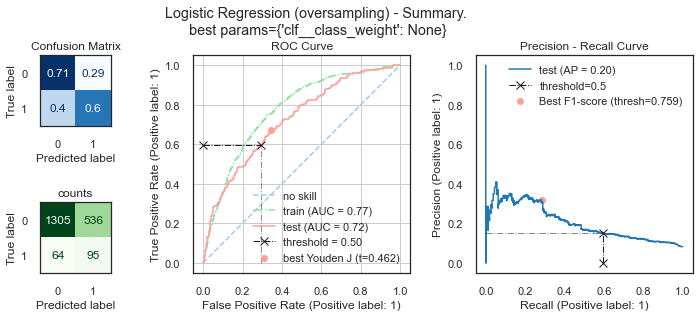

In [102]:
# Random oversampling
model_name = 'Logistic Regression (oversampling)'
oversampler = RandomOverSampler(random_state=RANDOM_SEED)
x_train_over, y_train_over = oversampler.fit_resample(x_train_prep, y_train)

lr_pipeline = imbpipeline.Pipeline(steps=[
    # ('preprocess',numeric_pipeline),
    # ('sampling', oversampler),
    # ('feat_select','passthrough'),
    ('clf', LogisticRegression(penalty='l1', solver='liblinear')),
])
param_grid = {
    # 'sampling':[undersampler],
    'clf__class_weight': [None, 'balanced'],
    # 'clf__solver':['lbfgs','liblinear']
}
evaluate_model(model_name, lr_pipeline, x_train_over, y_train_over,
            x_test_prep, y_test, param_grid)


In [103]:

# cleanup
del x_train_over, y_train_over


### Logistic Regression SMOTE (auto)

Synthetic Minority Oversampling Technique (SMOTE)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
GridSearchCV took 19.175 s
Best Parameters: {'clf__class_weight': None}
Best Test Score (roc_auc): 0.787
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (Logistic Regression SMOTE (auto); training time = 9.6 s; estimated gridsearch time (10 splits) = 96.24 s
add_model_score, model = Logistic Regression SMOTE (auto)
{'logloss': 10.258, 'precision': 0.151, 'recall': 0.591, 'f05': 0.177, 'f1': 0.24, 'f2': 0.373, 'f5': 0.532, 'bank_scorer': 0.668, 'roc_auc': 0.718}
Plotting results for Logistic Regression SMOTE (auto) with best_params : {'clf__class_weight': None}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.95      0.71      0.82      1841
           1       0.15      0.59      0.24       159

    accuracy                           0.70      2000
   macro avg       0.55      0.65      0.53      2000
weighted avg       0.89      0.70      0.7

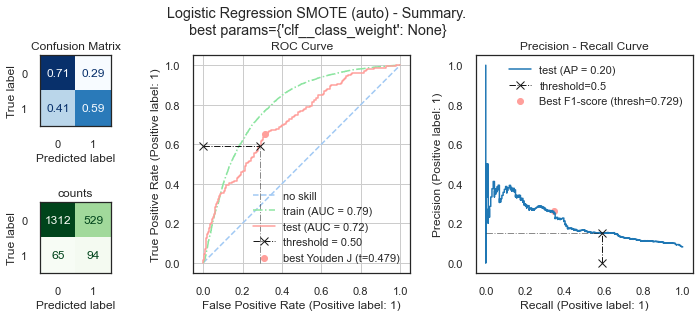

In [104]:
model_name = 'Logistic Regression SMOTE (auto)'
smote_auto = SMOTE(random_state=RANDOM_SEED)
x_train_smote, y_train_smote = smote_auto.fit_resample(x_train_prep, y_train)

lr_pipeline = imbpipeline.Pipeline(steps=[
    # ('preprocess',numeric_pipeline),
    # ('sampling', smote_auto),
    # ('feat_select','passthrough'),
    ('clf', LogisticRegression(penalty='l1', solver='liblinear')),
])
param_grid = {
    # 'sampling':[smote_adasyn],
    'clf__class_weight': [None, 'balanced'],
    # 'clf__penalty':['l1','l2', 'ElasticNet'],
    # 'clf__solver':['liblinear']
}
evaluate_model(model_name, lr_pipeline, x_train_smote, y_train_smote,
            x_test_prep, y_test, param_grid)


In [105]:
# cleanup
del x_train_smote, y_train_smote


### Logistic Regression SMOTE (borderline)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
GridSearchCV took 16.636 s
Best Parameters: {'clf__class_weight': 'balanced'}
Best Test Score (roc_auc): 0.831
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (Logistic Regression SMOTE (borderline); training time = 8.0 s; estimated gridsearch time (10 splits) = 80.25 s
add_model_score, model = Logistic Regression SMOTE (borderline)
{'logloss': 9.17, 'precision': 0.161, 'recall': 0.553, 'f05': 0.187, 'f1': 0.249, 'f2': 0.372, 'f5': 0.506, 'bank_scorer': 0.677, 'roc_auc': 0.719}
Plotting results for Logistic Regression SMOTE (borderline) with best_params : {'clf__class_weight': 'balanced'}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      1841
           1       0.16      0.55      0.25       159

    accuracy                           0.73      2000
   macro avg       0.56      0.65      0.54      2000
weighted avg 

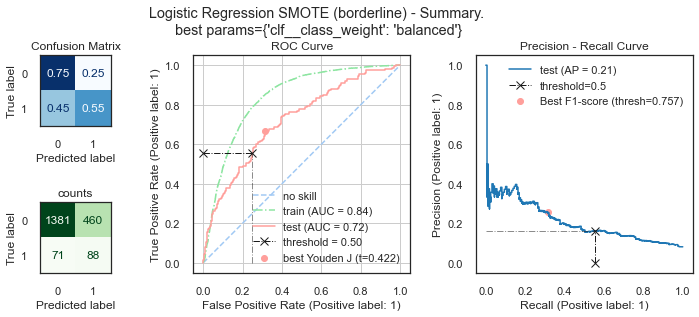

In [106]:
from imblearn.over_sampling import BorderlineSMOTE
model_name = 'Logistic Regression SMOTE (borderline)'
smote_border = BorderlineSMOTE(random_state=RANDOM_SEED)
x_train_border, y_train_border = smote_border.fit_resample(
    x_train_prep, y_train)

lr_pipeline = imbpipeline.Pipeline(steps=[
    # ('preprocess',numeric_pipeline),
    # ('sampling', smote_auto),
    # ('feat_select','passthrough'),
    ('clf', LogisticRegression(penalty='l1', solver='liblinear')),
])
param_grid = {
    # 'sampling':[smote_borderline],
    'clf__class_weight': [None, 'balanced'],
    # 'penalty':['l1','l2', 'ElasticNet'],
    # 'solver':['lbfgs','liblinear']
}
evaluate_model(model_name, lr_pipeline, x_train_border, y_train_border,
            x_test_prep, y_test, param_grid)


In [107]:
# cleanup
del x_train_border, y_train_border


### Logistic Regression SMOTE Tomek links


Fitting 5 folds for each of 1 candidates, totalling 5 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV took 1.499 s
Best Parameters: {}
Best Test Score (roc_auc): 0.787


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (Logistic Regression SMOTE TomekLinks; training time = 0.68 s; estimated gridsearch time (5 splits) = 3.515 s
add_model_score, model = Logistic Regression SMOTE TomekLinks
{'logloss': 10.189, 'precision': 0.153, 'recall': 0.597, 'f05': 0.18, 'f1': 0.244, 'f2': 0.378, 'f5': 0.537, 'bank_scorer': 0.671, 'roc_auc': 0.717}
Plotting results for Logistic Regression SMOTE TomekLinks with best_params : {}


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.95      0.71      0.82      1841
           1       0.15      0.60      0.24       159

    accuracy                           0.70      2000
   macro avg       0.55      0.66      0.53      2000
weighted avg       0.89      0.70      0.77      2000

1-specificity(FPR) = 0.29, sensitivity(TPR) 0.60
best threshold for roc_auc : 0.450 (score = 0.662)
best threshold for f2 : 0.450 (score = 0.386)
best threshold for bank_scorer : 0.700 (score = 0.697)
Best Threshold=0.477, Youden J =0.338
Best Threshold=0.731, F-Score=0.299
"Logistic_Regression_SMOTE_TomekLinks_-_Summary-_best_params={}.png"


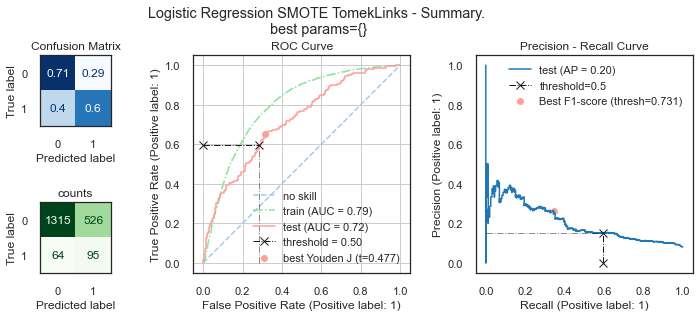

In [108]:
model_name = 'Logistic Regression SMOTE TomekLinks'
# over-sample borderline, then undersample)
smote_tomek = SMOTETomek(random_state=RANDOM_SEED)
x_train_tomek, y_train_tomek = smote_tomek.fit_resample(x_train_prep, y_train)

lr_pipeline = imbpipeline.Pipeline(steps=[
    # ('preprocess',numeric_pipeline),
    # ('sampling', smote_tomek),
    # ('feat_select','passthrough'),
    ('clf', LogisticRegression()),
])

param_grid = {
    # 'sampling':[smote_tomek, smote_enn],
    #  'clf__class_weight':[None,'balanced'],
    # 'penalty':['l1','l2', 'ElasticNet'],
    # 'solver':['lbfgs','liblinear']
}
evaluate_model(model_name, lr_pipeline, x_train_tomek, y_train_tomek,
            x_test_prep, y_test, param_grid)


In [109]:
# cleanup
del x_train_tomek, y_train_tomek


### Logistic Regression SMOTE (ADASYN)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV took 2.146 s
Best Parameters: {}
Best Test Score (roc_auc): 0.765


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (Logistic Regression SMOTE ADASYN; training time = 0.85 s; estimated gridsearch time (5 splits) = 4.41 s
add_model_score, model = Logistic Regression SMOTE ADASYN
{'logloss': 10.517, 'precision': 0.152, 'recall': 0.616, 'f05': 0.179, 'f1': 0.243, 'f2': 0.382, 'f5': 0.551, 'bank_scorer': 0.671, 'roc_auc': 0.718}
Plotting results for Logistic Regression SMOTE ADASYN with best_params : {}


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1841
           1       0.15      0.62      0.24       159

    accuracy                           0.70      2000
   macro avg       0.55      0.66      0.53      2000
weighted avg       0.89      0.70      0.76      2000

1-specificity(FPR) = 0.30, sensitivity(TPR) 0.62
best threshold for roc_auc : 0.500 (score = 0.659)
best threshold for f2 : 0.500 (score = 0.382)
best threshold for bank_scorer : 0.700 (score = 0.703)
Best Threshold=0.464, Youden J =0.328
Best Threshold=0.698, F-Score=0.297
"Logistic_Regression_SMOTE_ADASYN_-_Summary-_best_params={}.png"


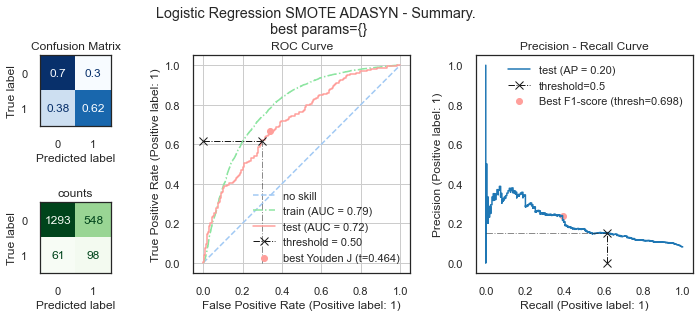

In [110]:
model_name = 'Logistic Regression SMOTE ADASYN'
# Smote + rnadomness
smote_adasyn = ADASYN(random_state=RANDOM_SEED)
x_train_adasyn, y_train_adasyn = smote_adasyn.fit_resample(
    x_train_prep, y_train)

lr_pipeline = imbpipeline.Pipeline(steps=[
    # ('preprocess',numeric_pipeline),
    # ('sampling', smote_adasyn),
    # ('feat_select','passthrough'),
    ('clf', LogisticRegression()),
])

param_grid = {
    # 'sampling':[smote_adasyn],
    #  'clf__class_weight':[None,'balanced'],
    # 'penalty':['l1','l2', 'ElasticNet'],
    # 'solver':['lbfgs','liblinear']
}
evaluate_model(model_name, lr_pipeline, x_train_adasyn, y_train_adasyn,
            x_test_prep, y_test, param_grid)


In [111]:
# cleanup
del x_train_adasyn, y_train_adasyn


### Logistic Regression - Compare sampling strategies

In [112]:
lr_filtre = df_scores['model_name'].str.contains(
    'Logistic Regress', case=False)
df_lr = df_scores[lr_filtre]
df_lr.head()


model_name                             params  \
3    Logistic Regression (cost-sensitive)  {'clf__class_weight': 'balanced'}   
4     Logistic Regression (undersampling)        {'clf__class_weight': None}   
5      Logistic Regression (oversampling)        {'clf__class_weight': None}   
6        Logistic Regression SMOTE (auto)        {'clf__class_weight': None}   
7  Logistic Regression SMOTE (borderline)  {'clf__class_weight': 'balanced'}   

   train_time  gridsearch_time  logloss  precision  recall    f05     f1  \
3       0.014             0.62   10.396      0.152   0.610  0.179  0.244   
4       0.097             0.45   11.053      0.148   0.635  0.175  0.240   
5       1.830            43.27   10.362      0.151   0.597  0.177  0.241   
6       4.425            96.24   10.258      0.151   0.591  0.177  0.240   
7       5.853            80.25    9.170      0.161   0.553  0.187  0.249   

      f2     f5  bank_scorer  roc_auc  best_cv_score  \
3  0.381  0.547        0.671    0.658          0.723   
4  0.383  0.564        0.666    0.660          0.697   
5  0.375  0.536        0.668    0.653          0.766   
6  0.373  0.532        0.668    0.652          0.787   
7  0.372  0.506        0.677    0.652          0.831   

   discrimination_threshold  mean_test_bank_scorer  mean_test_f2_scorer  \
3                       0.5                  0.677                0.397   
4                       0.5                  0.644                0.644   
5                       0.5                  0.709                0.709   
6                       0.5                  0.736                0.735   
7                       0.5                  0.781                0.779   

   mean_test_roc_auc  mean_train_bank_scorer  mean_train_f2_scorer  \
3              0.723                     NaN                   NaN   
4              0.697                     NaN                   NaN   
5              0.766                     NaN                   NaN   
6              0.787                     NaN                   NaN   
7              0.831                     NaN                   NaN   

   mean_train_roc_auc  \
3                 NaN   
4                 NaN   
5                 NaN   
6                 NaN   
7                 NaN   

                                                                             model  \
3                                       (RidgeClassifier(class_weight='balanced'))   
4                                                           (LogisticRegression())   
5                           (LogisticRegression(penalty='l1', solver='liblinear'))   
6                           (LogisticRegression(penalty='l1', solver='liblinear'))   
7  (LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear'))   

   refit_time  std_test_bank_scorer  std_test_f2_scorer  std_test_roc_auc  \
3      0.0261                0.0144              0.0243            0.0204   
4      0.0855                0.0340              0.0338            0.0280   
5      1.6700                0.0126              0.0125            0.0102   
6      4.7500                0.0178              0.0171            0.0102   
7      2.6700                0.0266              0.0258            0.0175   

   std_train_bank_scorer  std_train_f2_scorer  std_train_roc_auc  
3                    NaN                  NaN                NaN  
4                    NaN                  NaN                NaN  
5                    NaN                  NaN                NaN  
6                    NaN                  NaN                NaN  
7                    NaN                  NaN                NaN

invalid value encountered in reduce
invalid value encountered in reduce


"Cross-validation_score_(roc_auc)_-_Logistic_Regression.png"


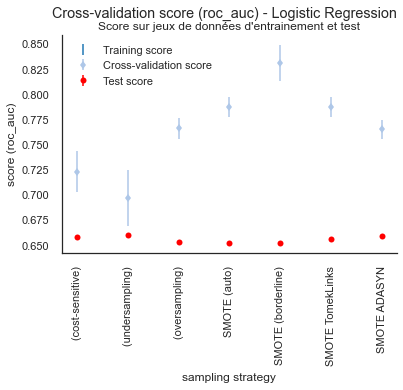

In [113]:
def plot_cv_scores(scores: pd.DataFrame, score='roc_auc', cible=None, figname=''):
    """Comparer les cross-validation scores de chaque model sur le jeu de données train"""
    scores = scores.copy()
    if not cible is None:
        scores = scores[scores['model_name'].str.contains(
            cible, case=False, regex=True)]
        if not '|' in cible:
            # if cible is not a regular expression
            scores['model_name'] = scores['model_name'].str.replace(cible, '')
    if f'mean_train_{score}' in scores.columns:
        plt.errorbar(x=scores['model_name'], y=scores[f'mean_train_{score}'],
                     yerr=scores[f'std_train_{score}'], fmt="+", label="Training score")
    if f'mean_test_{score}' in scores.columns:
        plt.errorbar(x=scores['model_name'], y=scores[f'mean_test_{score}'],
                     yerr=scores[f'std_test_{score}'], fmt="d", label="Cross-validation score")
    if f'{score}' in scores.columns:
        plt.errorbar(x=scores['model_name'], y=scores[score],
                     yerr=0, fmt="o", color="red", label="Test score")
    ax = plt.gca()
    plt.legend(loc='best')
    plt.xticks(rotation=90)
    plt.xlabel(f'model name')
    plt.ylabel(f'score ({score})')
    sns.despine()
    suptitre = f'Cross-validation score ({score})'
    if not cible is None:
        suptitre += f' - {cible}'
    plt.suptitle(suptitre)
    plt.title(f"Score sur jeux de données d'entrainement et test")


plot_cv_scores(df_scores, cible='Logistic Regression')
plt.xlabel('sampling strategy')
to_png()


invalid value encountered in reduce
invalid value encountered in reduce


"Cross-validation_score_(bank_scorer)_-_Logistic_Regression.png"


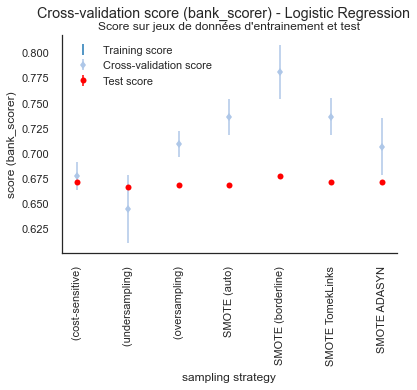

In [114]:
plot_cv_scores(df_scores, score='bank_scorer', cible='Logistic Regression')
plt.xlabel('sampling strategy')
to_png()


invalid value encountered in reduce
invalid value encountered in reduce


"Cross-validation_score_(f2_scorer)_-_Logistic_Regression.png"


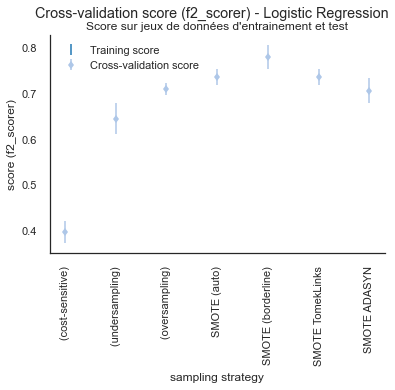

In [115]:
plot_cv_scores(df_scores, score='f2_scorer', cible='Logistic Regression')
plt.xlabel('sampling strategy')
to_png()


### Sampling strategy conclusions (Logistic Regression)

L'utilisation d'un sampling strategy n'améliore pas beaucoup le score de LogisticRegression

- Les meilleurs résultats sont avec SMOTE borderline


## Random Forest Classifier


In [116]:
print(RandomForestClassifier().get_params())


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### Random Forest avec réequilibrage des classes (class_weight = balanced)


Fitting 5 folds for each of 14 candidates, totalling 70 fits
GridSearchCV took 46.151 s
Best Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 8}
Best Test Score (roc_auc): 0.733
bestmodel type =  <class 'sklearn.pipeline.Pipeline'>
time_model (Random Forest (cost-sensitive); training time = 4.4 s; estimated gridsearch time (70 splits) = 319.9 s
add_model_score, model = Random Forest (cost-sensitive)
{'logloss': 4.058, 'precision': 0.284, 'recall': 0.314, 'f05': 0.29, 'f1': 0.299, 'f2': 0.308, 'f5': 0.313, 'bank_scorer': 0.703, 'roc_auc': 0.754}
Plotting results for Random Forest (cost-sensitive) with best_params : {'clf__criterion': 'gini', 'clf__max_depth': 8}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1841
           1       0.28      0.31      0.30       159

    accuracy                           0.88      2000
   macro avg       0.61      0.62      0.62      2000
weighted 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


best threshold for roc_auc : 0.350 (score = 0.692)
best threshold for f2 : 0.350 (score = 0.419)
best threshold for bank_scorer : 0.400 (score = 0.710)
Best Threshold=0.340, Youden J =0.389
Best Threshold=0.527, F-Score=0.318
"Random_Forest_(cost-sensitive)_-_Summary-_best_params={'clf__criterion'-_'gini',_'clf__max_depth'-_8}.png"


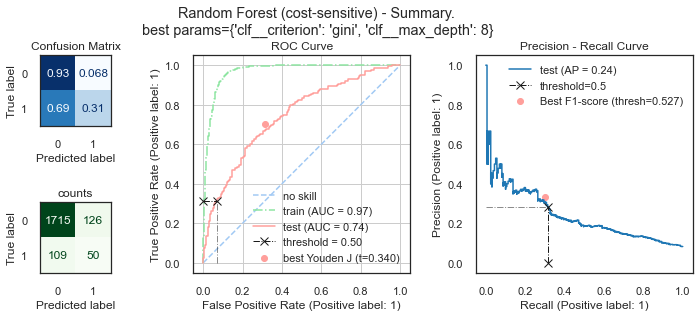

In [117]:


model_name = 'Random Forest (cost-sensitive)'
rfc_pipeline = Pipeline(steps=[
    # ('preprocess', numeric_pipeline),
    # ('sampling', 'passthrough'),
    # ('feat_select', 'passthrough'),
    ('clf', RandomForestClassifier(class_weight='balanced', max_features='auto'))
])

param_grid = {
    'clf__max_depth': range(3, 10),
    'clf__criterion': ['gini', 'entropy']}

evaluate_model(model_name, rfc_pipeline, x_train_prep, y_train,
            x_test_prep, y_test, param_grid)


In [118]:
plot_best_param_scores(gs, 'clf__max_depth')


20


'param_clf__max_depth not in cross-validation results'

### RandomForest avec SMOTE


Fitting 5 folds for each of 14 candidates, totalling 70 fits
GridSearchCV took 109.891 s
Best Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 9}
Best Test Score (roc_auc): 0.978
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (Random Forest SMOTE; training time = 11.0 s; estimated gridsearch time (70 splits) = 789.6 s
add_model_score, model = Random Forest SMOTE
{'logloss': 4.697, 'precision': 0.224, 'recall': 0.289, 'f05': 0.235, 'f1': 0.253, 'f2': 0.273, 'f5': 0.286, 'bank_scorer': 0.683, 'roc_auc': 0.75}
Plotting results for Random Forest SMOTE with best_params : {'clf__criterion': 'gini', 'clf__max_depth': 9}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1841
           1       0.22      0.29      0.25       159

    accuracy                           0.86      2000
   macro avg       0.58      0.60      0.59      2000
weighted avg       0.88      0.86      

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


best threshold for roc_auc : 0.300 (score = 0.683)
best threshold for f2 : 0.350 (score = 0.409)
best threshold for bank_scorer : 0.450 (score = 0.705)
Best Threshold=0.329, Youden J =0.403
Best Threshold=0.428, F-Score=0.299
"Random_Forest_SMOTE_-_Summary-_best_params={'clf__criterion'-_'gini',_'clf__max_depth'-_9}.png"


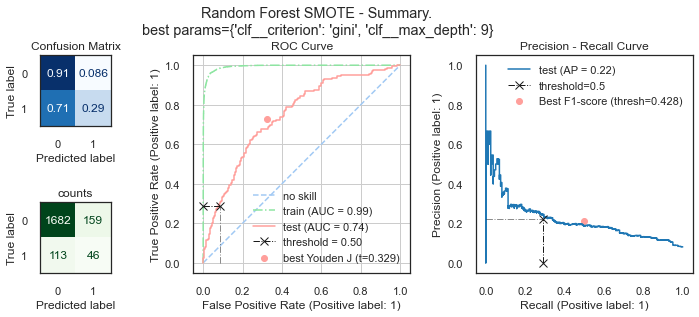

In [119]:
model_name = 'Random Forest SMOTE'
# over-sample borderline, then undersample)
smote_auto = SMOTE(random_state=RANDOM_SEED)
x_train_smote, y_train_smote = smote_auto.fit_resample(x_train_prep, y_train)

rfc_pipeline = imbpipeline.Pipeline(steps=[
    # ('preprocess',numeric_pipeline),
    # ('sampling', smote_auto),
    # ('feat_select', 'passthrough'),
    ('clf', RandomForestClassifier(max_features='auto'))
])

param_grid = {
    'clf__max_depth': range(3, 10),
    'clf__criterion': ['gini', 'entropy']
}

evaluate_model(model_name, rfc_pipeline, x_train_smote, y_train_smote,
            x_test_prep, y_test, param_grid)


In [120]:
# cleanup
del x_train_smote, y_train_smote


SMOTE ne semble pas ameliorer les scores


## LGBMClassifier


In [121]:
print(LGBMClassifier().get_params())


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


### LGBMClassifier with class weights

On utilise class_weight='balanced' pour ajuster le poids


dict_keys(['memory', 'steps', 'verbose', 'clf', 'clf__boosting_type', 'clf__class_weight', 'clf__colsample_bytree', 'clf__importance_type', 'clf__learning_rate', 'clf__max_depth', 'clf__min_child_samples', 'clf__min_child_weight', 'clf__min_split_gain', 'clf__n_estimators', 'clf__n_jobs', 'clf__num_leaves', 'clf__objective', 'clf__random_state', 'clf__reg_alpha', 'clf__reg_lambda', 'clf__silent', 'clf__subsample', 'clf__subsample_for_bin', 'clf__subsample_freq'])
Fitting 5 folds for each of 21 candidates, totalling 105 fits
GridSearchCV took 43.623 s
Best Parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': 3, 'clf__min_child_samples': 50}
Best Test Score (roc_auc): 0.735
bestmodel type =  <class 'sklearn.pipeline.Pipeline'>
time_model (LGBM (weight-balanced); training time = 2.9 s; estimated gridsearch time (105 splits) = 309.96 s
add_model_score, model = LGBM (weight-balanced)
{'logloss': 8.03, 'precision': 0.192, 'recall': 0.597, 'f05': 0.222, 'f1': 0.29, 'f2': 0.42, 'f5'

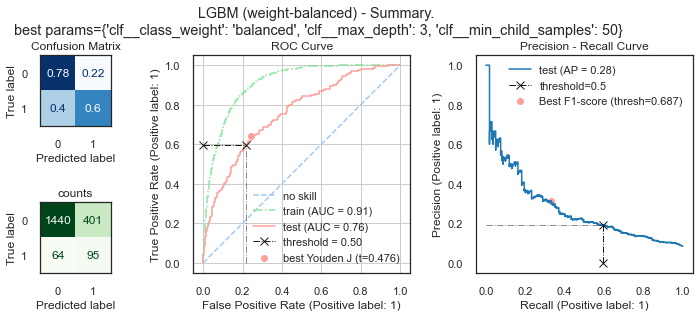

In [122]:
model_name = 'LGBM (weight-balanced)'
lgbm_pipeline = Pipeline(steps=[
    # ('preprocess', numeric_pipeline),
    # ('sampling', 'passthrough'),
    # ('feat_select', 'passthrough'),
    ('clf', LGBMClassifier(class_weight='balanced'))
])
print(lgbm_pipeline.get_params().keys())

param_grid = {
    'clf__class_weight': ['balanced'],
    'clf__max_depth': range(3, 10),
    'clf__min_child_samples': [5, 10, 50],
    #  'clf__reg_lambda': np.logspace(-4,1,5),
    #  'clf__reg_alpha': np.logspace(-4,1,5)
}
evaluate_model(model_name, lgbm_pipeline, x_train_prep, y_train,
            x_test_prep, y_test, param_grid)


In [123]:
plot_best_param_scores(gs, 'clf__max_depth')


20


'param_clf__max_depth not in cross-validation results'

In [124]:
plot_best_param_scores(gs, 'clf__max_depth', scorers=['bank_scorer'])


20


'param_clf__max_depth not in cross-validation results'

### LGBM Classifier avec SMOTE


Fitting 5 folds for each of 21 candidates, totalling 105 fits
GridSearchCV took 71.493 s
Best Parameters: {'clf__max_depth': 8, 'clf__min_child_samples': 50}
Best Test Score (roc_auc): 0.984
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (LGBM (SMOTE); training time = 5.0 s; estimated gridsearch time (105 splits) = 533.4 s
add_model_score, model = LGBM (SMOTE)
{'logloss': 3.005, 'precision': 0.358, 'recall': 0.119, 'f05': 0.256, 'f1': 0.179, 'f2': 0.138, 'f5': 0.123, 'bank_scorer': 0.663, 'roc_auc': 0.733}
Plotting results for LGBM (SMOTE) with best_params : {'clf__max_depth': 8, 'clf__min_child_samples': 50}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1841
           1       0.36      0.12      0.18       159

    accuracy                           0.91      2000
   macro avg       0.64      0.55      0.57      2000
weighted avg       0.88      0.91      0.89      20

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


best threshold for roc_auc : 0.100 (score = 0.682)
best threshold for f2 : 0.100 (score = 0.408)
best threshold for bank_scorer : 0.250 (score = 0.699)
Best Threshold=0.112, Youden J =0.373
Best Threshold=0.248, F-Score=0.295
"LGBM_(SMOTE)_-_Summary-_best_params={'clf__max_depth'-_8,_'clf__min_child_samples'-_50}.png"


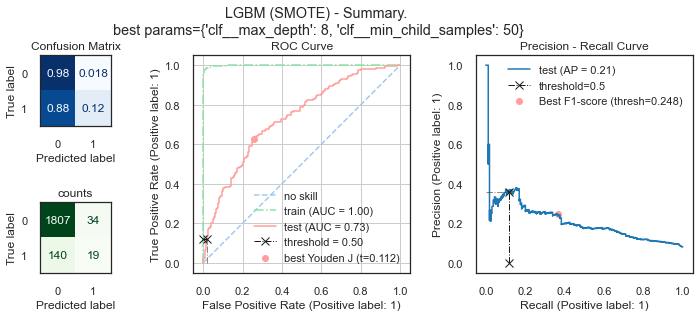

In [125]:
model_name = 'LGBM (SMOTE)'
smote_auto = SMOTE(random_state=RANDOM_SEED)
x_train_smote, y_train_smote = smote_auto.fit_resample(x_train_prep, y_train)

lgbm_pipeline = imbpipeline.Pipeline(steps=[
    # ('preprocess',numeric_pipeline),
    # ('sampling', smote_auto),
    # ('feat_select', 'passthrough'),
    ('clf', LGBMClassifier())
])
param_grid = {
    'clf__max_depth': range(3, 10),
    'clf__min_child_samples': [5, 10, 50],
    #  'clf__reg_lambda': np.logspace(-4,1,5),
    #  'clf__reg_alpha': np.logspace(-4,1,5)
}

evaluate_model(model_name, lgbm_pipeline, x_train_smote, y_train_smote,
            x_test_prep, y_test, param_grid)


In [126]:
# cleanup
del x_train_smote, y_train_smote


### LGBM Classifier avec SMOTE borderline

Fitting 5 folds for each of 21 candidates, totalling 105 fits
GridSearchCV took 68.978 s
Best Parameters: {'clf__max_depth': 9, 'clf__min_child_samples': 50}
Best Test Score (roc_auc): 0.984
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (LGBM BorderlineSMOTE; training time = 4.9 s; estimated gridsearch time (105 splits) = 523.005 s
add_model_score, model = LGBM BorderlineSMOTE
{'logloss': 2.97, 'precision': 0.382, 'recall': 0.132, 'f05': 0.277, 'f1': 0.196, 'f2': 0.152, 'f5': 0.135, 'bank_scorer': 0.667, 'roc_auc': 0.738}
Plotting results for LGBM BorderlineSMOTE with best_params : {'clf__max_depth': 9, 'clf__min_child_samples': 50}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1841
           1       0.38      0.13      0.20       159

    accuracy                           0.91      2000
   macro avg       0.66      0.56      0.58      2000
weighted avg       0.89   

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


best threshold for roc_auc : 0.100 (score = 0.668)
best threshold for f2 : 0.100 (score = 0.392)
best threshold for bank_scorer : 0.150 (score = 0.705)
Best Threshold=0.126, Youden J =0.361
Best Threshold=0.281, F-Score=0.299
"LGBM_BorderlineSMOTE_-_Summary-_best_params={'clf__max_depth'-_9,_'clf__min_child_samples'-_50}.png"


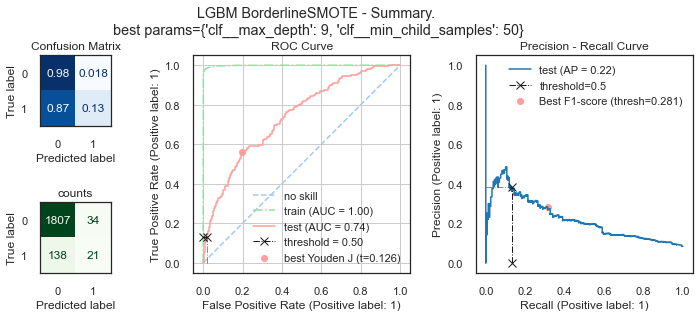

In [127]:
model_name= 'LGBM BorderlineSMOTE'
smote_border = BorderlineSMOTE(random_state=RANDOM_SEED)
x_train_border, y_train_border = smote_border.fit_resample(
    x_train_prep, y_train)

lgbm_pipeline = imbpipeline.Pipeline([('clf', LGBMClassifier())])
param_grid = {
    'clf__max_depth': range(3, 10),
    'clf__min_child_samples': [5, 10, 50],
    #  'clf__reg_lambda': np.logspace(-4,1,5),
    #  'clf__reg_alpha': np.logspace(-4,1,5)
}

evaluate_model(model_name, lgbm_pipeline, x_train_border, y_train_border,
            x_test_prep, y_test, param_grid)

In [128]:
# cleanup
del x_train_border, y_train_border

### LGBM Classifier avec SMOTE Tomek links

Fitting 5 folds for each of 21 candidates, totalling 105 fits
GridSearchCV took 67.947 s
Best Parameters: {'clf__max_depth': 8, 'clf__min_child_samples': 50}
Best Test Score (roc_auc): 0.984
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (LGBM (SMOTE_Tomek); training time = 4.8 s; estimated gridsearch time (105 splits) = 512.295 s
add_model_score, model = LGBM (SMOTE_Tomek)
{'logloss': 3.005, 'precision': 0.358, 'recall': 0.119, 'f05': 0.256, 'f1': 0.179, 'f2': 0.138, 'f5': 0.123, 'bank_scorer': 0.663, 'roc_auc': 0.733}
Plotting results for LGBM (SMOTE_Tomek) with best_params : {'clf__max_depth': 8, 'clf__min_child_samples': 50}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1841
           1       0.36      0.12      0.18       159

    accuracy                           0.91      2000
   macro avg       0.64      0.55      0.57      2000
weighted avg       0.88      0.

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


best threshold for roc_auc : 0.100 (score = 0.682)
best threshold for f2 : 0.100 (score = 0.408)
best threshold for bank_scorer : 0.250 (score = 0.699)
Best Threshold=0.112, Youden J =0.373
Best Threshold=0.248, F-Score=0.295
"LGBM_(SMOTE_Tomek)_-_Summary-_best_params={'clf__max_depth'-_8,_'clf__min_child_samples'-_50}.png"


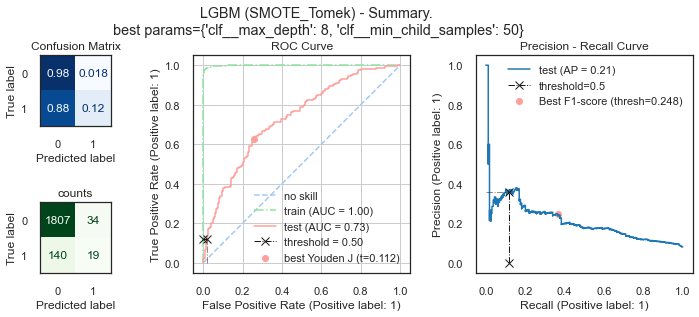

In [129]:
model_name = 'LGBM (SMOTE_Tomek)'
smote_tomek = SMOTETomek(random_state=RANDOM_SEED)
x_train_tomek, y_train_tomek = smote_tomek.fit_resample(x_train_prep, y_train)

lgbm_pipeline = imbpipeline.Pipeline(steps=[
    # ('preprocess',numeric_pipeline),
    # ('sampling', smote_tomek),
    # ('feat_select', 'passthrough'),
    ('clf', LGBMClassifier())
])
param_grid = {
    'clf__max_depth': range(3, 10),
    'clf__min_child_samples': [5, 10, 50],
    #  'clf__reg_lambda': np.logspace(-4,1,5),
    #  'clf__reg_alpha': np.logspace(-4,1,5)
}

evaluate_model(model_name, lgbm_pipeline, x_train_tomek, y_train_tomek,
            x_test_prep, y_test, param_grid)


In [130]:
# cleanup
del x_train_tomek, y_train_tomek


# Comparaison des scores des modeles


In [131]:
print(df_scores.columns.tolist())


['model_name', 'params', 'train_time', 'gridsearch_time', 'logloss', 'precision', 'recall', 'f05', 'f1', 'f2', 'f5', 'bank_scorer', 'roc_auc', 'best_cv_score', 'discrimination_threshold', 'mean_test_bank_scorer', 'mean_test_f2_scorer', 'mean_test_roc_auc', 'mean_train_bank_scorer', 'mean_train_f2_scorer', 'mean_train_roc_auc', 'model', 'refit_time', 'std_test_bank_scorer', 'std_test_f2_scorer', 'std_test_roc_auc', 'std_train_bank_scorer', 'std_train_f2_scorer', 'std_train_roc_auc']


invalid value encountered in reduce
invalid value encountered in reduce


"Cross-validation_score_(roc_auc).png"


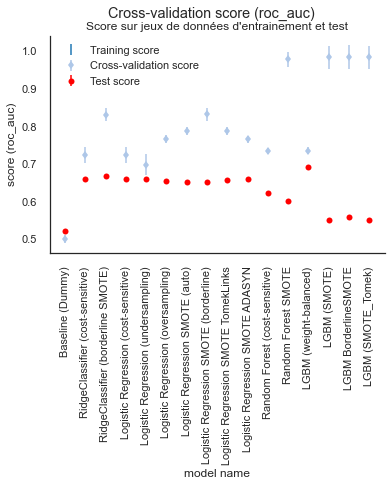

In [132]:
plot_cv_scores(df_scores)
to_png()


invalid value encountered in reduce
invalid value encountered in reduce


"Cross-validation_score_(bank_scorer).png"


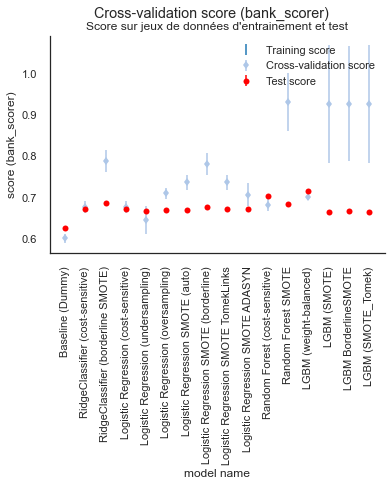

In [133]:
plot_cv_scores(df_scores, score='bank_scorer')
to_png()


invalid value encountered in reduce
invalid value encountered in reduce


"Cross-validation_score_(f2_scorer).png"


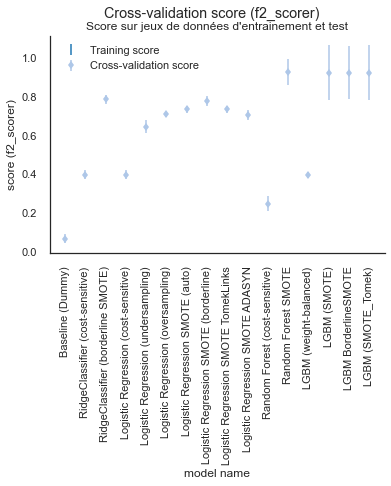

In [134]:
plot_cv_scores(df_scores, score='f2_scorer')
to_png()


In [135]:
df_scores = df_scores.sort_values(by='mean_test_roc_auc', ascending=False)
df_scores.head()


model_name  \
13                            LGBM (SMOTE)   
14                    LGBM BorderlineSMOTE   
15                      LGBM (SMOTE_Tomek)   
11                     Random Forest SMOTE   
7   Logistic Regression SMOTE (borderline)   

                                                 params  train_time  \
13  {'clf__max_depth': 8, 'clf__min_child_samples': 50}       0.980   
14  {'clf__max_depth': 9, 'clf__min_child_samples': 50}       0.975   
15  {'clf__max_depth': 8, 'clf__min_child_samples': 50}       0.995   
11      {'clf__criterion': 'gini', 'clf__max_depth': 9}       4.479   
7                     {'clf__class_weight': 'balanced'}       5.853   

    gridsearch_time  logloss  precision  recall    f05     f1     f2     f5  \
13          533.400    3.005      0.358   0.119  0.256  0.179  0.138  0.123   
14          523.005    2.970      0.382   0.132  0.277  0.196  0.152  0.135   
15          512.295    3.005      0.358   0.119  0.256  0.179  0.138  0.123   
11          789.600    4.697      0.224   0.289  0.235  0.253  0.273  0.286   
7            80.250    9.170      0.161   0.553  0.187  0.249  0.372  0.506   

    bank_scorer  roc_auc  best_cv_score  discrimination_threshold  \
13        0.663    0.551          0.984                       0.5   
14        0.667    0.557          0.984                       0.5   
15        0.663    0.551          0.984                       0.5   
11        0.683    0.601          0.978                       0.5   
7         0.677    0.652          0.831                       0.5   

    mean_test_bank_scorer  mean_test_f2_scorer  mean_test_roc_auc  \
13                  0.925                0.924              0.984   
14                  0.926                0.925              0.984   
15                  0.925                0.924              0.984   
11                  0.930                0.927              0.978   
7                   0.781                0.779              0.831   

    mean_train_bank_scorer  mean_train_f2_scorer  mean_train_roc_auc  \
13                     NaN                   NaN                 NaN   
14                     NaN                   NaN                 NaN   
15                     NaN                   NaN                 NaN   
11                     NaN                   NaN                 NaN   
7                      NaN                   NaN                 NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              model  \
13                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              (LGBMClassifier(max_depth=8, mi

In [136]:
df_scores2 = df_scores.rename(columns={'roc_auc': 'roc_auc_metric',
                                       'mean_test_bank_scorer': 'bank_scorer2',
                                       'mean_test_f2_scorer': 'f2_scorer',
                                       'mean_test_roc_auc': 'roc_auc'})

sel_cols = ['bank_scorer', 'f2_scorer', 'roc_auc', 'gridsearch_time',
            'logloss', 'precision', 'recall', 'f1', 'f2', 'f05', 'bank_scorer2']
pd.pivot_table(df_scores2, index=['model_name']).sort_values(
    by='roc_auc', ascending=False)


bank_scorer  bank_scorer2  \
model_name                                                          
LGBM (SMOTE)                                  0.663         0.925   
LGBM (SMOTE_Tomek)                            0.663         0.925   
LGBM BorderlineSMOTE                          0.667         0.926   
Random Forest SMOTE                           0.683         0.930   
Logistic Regression SMOTE (borderline)        0.677         0.781   
RidgeClassifier (borderline SMOTE)            0.687         0.788   
Logistic Regression SMOTE (auto)              0.668         0.736   
Logistic Regression SMOTE TomekLinks          0.671         0.736   
Logistic Regression (oversampling)            0.668         0.709   
Logistic Regression SMOTE ADASYN              0.671         0.706   
LGBM (weight-balanced)                        0.714         0.701   
Random Forest (cost-sensitive)                0.703         0.681   
Logistic Regression (cost-sensitive)          0.671         0.677   
RidgeClassifier (cost-sensitive)              0.671         0.677   
Logistic Regression (undersampling)           0.666         0.644   
Baseline (Dummy)                              0.625         0.600   

                                        best_cv_score  \
model_name                                              
LGBM (SMOTE)                                    0.984   
LGBM (SMOTE_Tomek)                              0.984   
LGBM BorderlineSMOTE                            0.984   
Random Forest SMOTE                             0.978   
Logistic Regression SMOTE (borderline)          0.831   
RidgeClassifier (borderline SMOTE)              0.830   
Logistic Regression SMOTE (auto)                0.787   
Logistic Regression SMOTE TomekLinks            0.787   
Logistic Regression (oversampling)              0.766   
Logistic Regression SMOTE ADASYN                0.765   
LGBM (weight-balanced)                          0.735   
Random Forest (cost-sensitive)                  0.733   
Logistic Regression (cost-sensitive)            0.723   
RidgeClassifier (cost-sensitive)                0.723   
Logistic Regression (undersampling)             0.697   
Baseline (Dummy)                                0.499   

                                        discrimination_threshold    f05  \
model_name                                                                
LGBM (SMOTE)                                                 0.5  0.256   
LGBM (SMOTE_Tomek)                                           0.5  0.256   
LGBM BorderlineSMOTE                                         0.5  0.277   
Random Forest SMOTE                                          0.5  0.235   
Logistic Regression SMOTE (borderline)                       0.5  0.187   
RidgeClassifier (borderline SMOTE)                           0.5  0.194   
Logistic Regression SMOTE (auto)                             0.5  0.177   
Logistic Regression SMOTE TomekLinks                         0.5  0.180   
Logistic Regression (oversampling)                           0.5  0.177   
Logistic Regression SMOTE ADASYN                             0.5  0.179   
LGBM (weight-balanced)                                       0.5  0.222   
Random Forest (cost-sensitive)                               0.5  0.290   
Logistic Regression (cost-sensitive)                         0.5  0.179   
RidgeClassifier (cost-sensitive)                             0.5  0.179   
Logistic Regression (undersampling)                          0.5  0.175   
Baseline (Dummy)                                             0.5  0.117   

                                           f1     f2  f2_scorer     f5  \
model_name                                                               
LGBM (SMOTE)                            0.179  0.138     0.9240  0.123   
LGBM (SMOTE_Tomek)                      0.179  0.138     0.9240  0.123   
LGBM BorderlineSMOTE                    0.196  0.152     0.9250  0.135   
Random Forest SMOTE                     0.253  0.

## Choix du meilleur model

La meilleur model semble être Logistic Regression avec Borderline SMOTE

On va voir si on peut améliorer le threshold pour augmenter le bank score


## Optimisation de benefit (score) pour la banque par fine-tuning du threshold

L'optimisation a été faite sur la métrique "roc_auc" (equilibre entre faux negatifs et faut positifs):

On peut ensuite optimiser le probability **discrimination threshold** (seuil) pour la banque d'accepter ou rejecter un prêt, basé sur:
(a) la métrique bancaire crée ci dessus; ou
(b) une autre mesure de profit et loss qui peut varie basé sur le montant de credit, durée de repaiement, ...

La section suivant on optimise le discrimination threshold pour la métrique bancaire `custom_credit_score`


### Optimisation of discrimination threshold


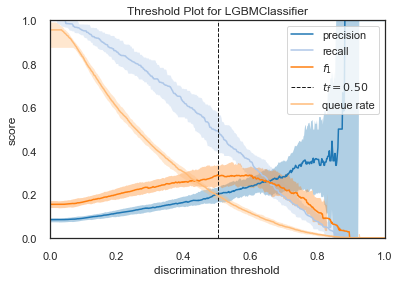

<AxesSubplot:title={'center':'Threshold Plot for LGBMClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [137]:
from yellowbrick.classifier import DiscriminationThreshold
lgbm_best_model_name='LGBM Classifier (balanced weights)'
lgbm_best_params=dict(class_weight='balanced', min_child_samples=50, max_depth=4)
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
visualizer = DiscriminationThreshold(lgbm_best_model)

visualizer.fit(x_train_prep, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure


Recalcule du best model

In [138]:
lr_best_model_name = 'Logistic Regression SMOTE (borderline)'
lr_best_model_row = df_scores[df_scores['model_name'] == lr_best_model_name]
lr_best_model = lr_best_model_row['model']
lr_best_params = lr_best_model_row['params'].values[0]
print(lr_best_params)


{'clf__class_weight': 'balanced'}


In [139]:
lr_best_model = LogisticRegression(
    penalty='l1', solver='liblinear', class_weight='balanced')
x_train_border, y_train_border = smote_border.fit_resample(
    x_train_prep, y_train)
lr_best_model.fit(x_train_border, y_train_border)


LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

X does not have valid feature names, but LogisticRegression was fitted with feature names


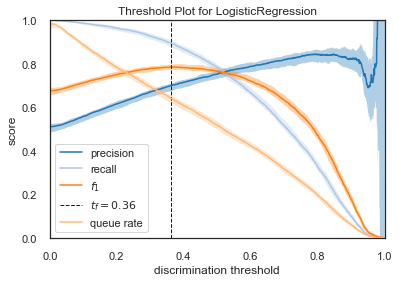

<AxesSubplot:title={'center':'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [140]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(lr_best_model)

# Fit the data to the visualizer
visualizer.fit(x_train_border, y_train_border)

visualizer.show()           # Finalize and render the figure


### Calcul du seuil de discrimination des classes


"LGBM_-_Calcul_de_seuil_de_probabilité_optimal.png"


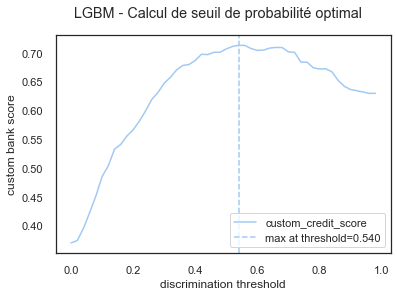

In [141]:
def plot_vline(df, x_col, y_col, ax, color='k', line_at='max'):
    """draw a vertical line at max or min value of y on a plot"""
    row_idx=0
    if line_at == 'max':
        row_idx = df[y_col].argmax()
    elif line_at == 'min':
        row_idx = df[y_col].argmin()
    line_x = df.loc[row_idx, x_col]
    line_label = f'{line_at} at {x_col}={line_x:.3f}'
    ax.axvline(line_x, c=color, linestyle="--", label=line_label)
    ax.legend(frameon=True)


def discrimination_threshold(clf: BaseEstimator, x_test_, y_test_, score_func=custom_credit_score,
                             label=None, color='b', ax=None):
    """
    calculate scores as function of threshold for discriminating class 0 and class 1 

    """
    scores = []
    thresholds = np.linspace(0, 1., 50, endpoint=False)

    # Probability of being in class TARGET==1
    y_pred_proba = clf.predict_proba(x_test_)[:, 1]
    for threshold in thresholds:
        # convert probability into class label, based on threshold
        y_pred = (y_pred_proba > threshold)*1
        scores.append(score_func(y_test_, y_pred, zero_division=0))
    if ax is None:
        _, ax = plt.subplots()
    if label is None:
        label = f'{score_func.__name__}'
    sns.lineplot(x=thresholds, y=scores, label=label, color=color, ax=ax)
    plot_vline(pd.DataFrame({'threshold': thresholds, 'score': scores}),
               'threshold', 'score', color=color, ax=ax)
    ax.set_xlabel("discrimination threshold")
    ax.set_ylabel("score")


_, ax = plt.subplots()


discrimination_threshold(lgbm_best_model, x_test_prep, y_test, ax=ax)
ax.set_ylabel("custom bank score")

plt.suptitle('LGBM - Calcul de seuil de probabilité optimal')
# plt.title(lgbm_best_model.get_params(), fontsize=8)
to_png()


"Logistic_Regression_SMOTE_(borderline)_-_Calcul_de_seuil_de_probabilité_optimal.png"


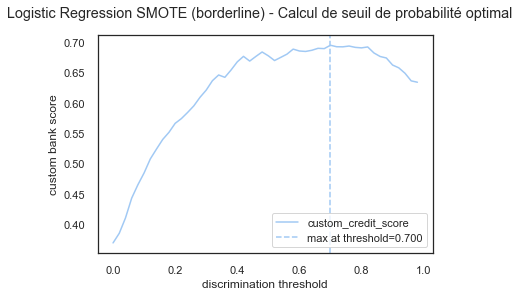

In [142]:
_, ax = plt.subplots()


discrimination_threshold(lr_best_model, x_test_prep, y_test, ax=ax)
ax.set_ylabel("custom bank score")

plt.suptitle(f'{lr_best_model_name} - Calcul de seuil de probabilité optimal')
# plt.title(lgbm_best_model.get_params(), fontsize=8)
to_png()


## Effet de changer les poids du metrique 'custom_credit_score'


In [143]:
def plot_probability_thresholds(model,x_val,y_val):
    _, ax = plt.subplots()
    colors = sns.color_palette('tab10').as_hex()

    # plot default threshold
    discrimination_threshold(model, x_val, y_val, color=colors[0], ax=ax)

    def score_fp_1(y_true_, y_pred_, **kwargs): 
        return custom_credit_score(y_true_, y_pred_, fp_loss=-0.2)
    
    def score_fp_2(y_true_, y_pred_,**kwargs): 
        return custom_credit_score(y_true_, y_pred_, fp_loss=-0.9)

    def score_fn_1(y_true_, y_pred_,**kwargs): 
        return custom_credit_score(y_true_, y_pred_, fn_loss=-5)

    def score_fn_2(y_true_, y_pred_, **kwargs): 
        return custom_credit_score(y_true_, y_pred_, fn_loss=-20)
        
    # reduire la perte suite à une mauvaise classification d'un bon client
    discrimination_threshold(model, x_val, y_val, score_func=score_fp_1,
                            label='fp_loss = -0.2', color=colors[1], ax=ax)

    # augmente la perte suite à un mauvaise classification d'un bon client
    discrimination_threshold(model, x_val, y_val, score_func=score_fp_2,
                            label='fp_loss = -0.9', color=colors[2], ax=ax)

    # reduire la perte suite à une mauvaise classification d'un mauvais client
    discrimination_threshold(model, x_val, y_val, score_func=score_fn_1,
                         label='fn_loss = -5',  color=colors[3], ax=ax)

    # augmente la perte suite à une mauvaise classification d'un mauvais client
    discrimination_threshold(model, x_val, y_val, score_func=score_fn_2,
                         label='fn_loss = -20',  color=colors[4], ax=ax)

    ax.grid(False)
    ax.set_ylabel("custom bank score")
    sns.despine()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


"Logistic_Regression_SMOTE_(borderline)_-_Effet_des_couts_des_faux_negatifs_et_faux_positifs_sur_le_seuil_de_probabilité_optimal.png"


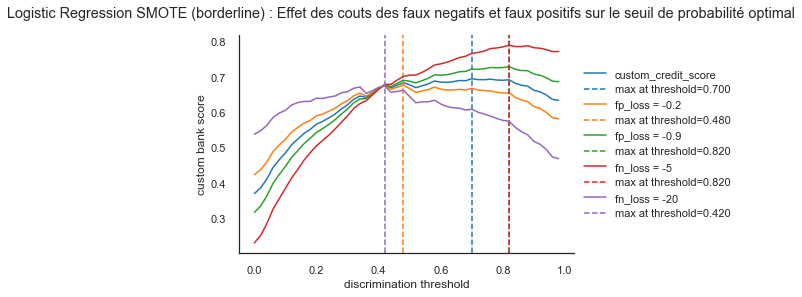

In [144]:

plot_probability_thresholds(lr_best_model, x_test_prep,y_test)

titre= lr_best_model_name
titre+=' : Effet des couts des faux negatifs et faux positifs sur le seuil de probabilité optimal'
plt.suptitle(titre)
to_png()


"LGBM_Classifier_(balanced_weights)_-_Effet_des_couts_des_faux_negatifs_et_faux_positifs_sur_le_seuil_de_probabilité_optimal.png"


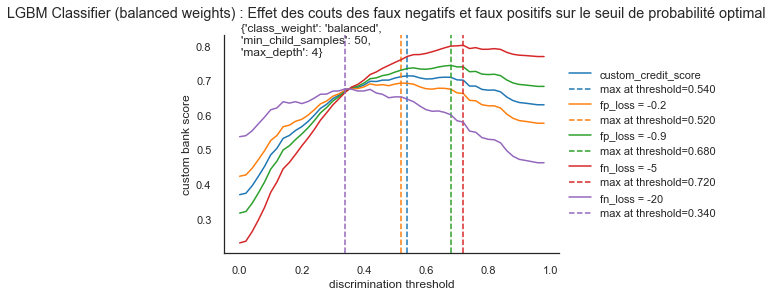

In [145]:
plot_probability_thresholds(lgbm_best_model, x_test_prep,y_test)
titre= lgbm_best_model_name
titre+=' : Effet des couts des faux negatifs et faux positifs sur le seuil de probabilité optimal'
plt.suptitle(titre)
params=f'{lgbm_best_params}'

ax=plt.gca()
add_text(ax, x=0.05,y=0.9,wrap=30,s=params)
to_png()


## Enregistre le meilleur model et les données

In [149]:

lgbm_best_model.fit(x_train_prep, y_train)

if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)

# fichiers de données clients à visualiser
datafiles=dict(
    x_test=x_test, 
    y_test=y_test,
    x_test_prep=x_test_prep, 
    )    
for key in datafiles.keys():
    save_pickle(datafiles[key],key,MODEL_FOLDER)


# enregistre le model
save_pickle(lgbm_best_model,'lgbm_best_model',MODEL_FOLDER)

In [150]:
smote_border=BorderlineSMOTE(random_state=RANDOM_SEED)
x_train_border, y_train_border=smote_border.fit_resample(x_train_prep,y_train)
lr_best_model.fit(x_train_border,y_train_border)

save_pickle(lr_best_model,'lr_best_model',MODEL_FOLDER)

# Chargement du meilleur modèle

On verifie que le model est bien enregistré

In [152]:
best_model_filepath = f'{MODEL_FOLDER}/lgbm_best_model.pickle'
try:
    best_model = load_pickle('lgbm_best_model',MODEL_FOLDER)
    best_model
except:
    print(f'File inexistante : {best_model_filepath}')




## Feature Importance

Deux mesures, valable seulement si le modèle a un bon niveau de prédiction

- (impurity-based) feature importance ('model.feature*importances*')
- (permutation-based) feature importance (sklearn.inspection.permutation_importance)

On peut aussi se basé sur 'mutual_info_classification' comme une proxy de 'feature importance', avant le fit du model


### (impurity-based) feature importance ('model.feature*\*importances*\*')

- computé sur le jeu d'entrainement pendant fit (TreeRegressors)
- basé sur 'entropy'
- peut avoir features trop important pour train mais pas très predictive (overfitting))
- bias vers les features avec grand cardinalité
- peut mettre trop d'importance pour les features numériques.


In [153]:
def plot_feature_importances(model, x_train_, model_name=''):
    """Plot feature importance basé sur le jeu d'entrainement """
    feature_importances = []
    model = get_classifier(model)
    if hasattr(model, 'estimators_'):
        if hasattr(model.estimators_[0], 'feature_importances_'):
            # Ensemble classifiers (DecisionTrees)
            feature_importances = np.mean([
                tree.feature_importances_ for tree in model.estimators_], axis=0)
    elif hasattr(model, 'feature_importances_'):
        # pas ensemble, decision tree ou autre non-linear regressors
        feature_importances = model.feature_importances_
    else:
        print('error: model.feature_importances_ ne sont pas present')
        return

    feature_importance = pd.Series(feature_importances,
                                   index=x_train_.columns)
    nb = min(len(x_train.columns), 10)
    print(feature_importance.sort_values(ascending=False).head(nb))
    feature_importance.sort_values(ascending=False).head(nb).plot(kind='barh')
    ax = plt.gca()
    ax.invert_yaxis()
    ax.set_ylabel('feature')
    ax.set_xlabel('feature_importance')
    plt.suptitle(f'{model_name} : Feature Importance')
    ax.set_title(f"jeu de données d'entrainement (top {nb} features)")
    add_text(ax, 0.3, 0.20,
             s=f"")
    sns.despine()
    to_png(f'{model_name}: Feature Importance entrainement')
    plt.show()


EXT_SOURCE_2                     78
EXT_SOURCE_3                     77
ANNUITY_INCOME_PERC              34
DAYS_BIRTH                       33
REGION_POPULATION_RELATIVE       32
POS_MONTHS_BALANCE_SIZE          32
EXT_SOURCE_1                     30
INSTAL_AMT_INSTALMENT_MAX        29
PAYMENT_RATE                     29
BURO_DAYS_CREDIT_ENDDATE_MEAN    29
dtype: int32
"LGBM_Classifier_(balanced_weights)-_Feature_Importance_entrainement.png"


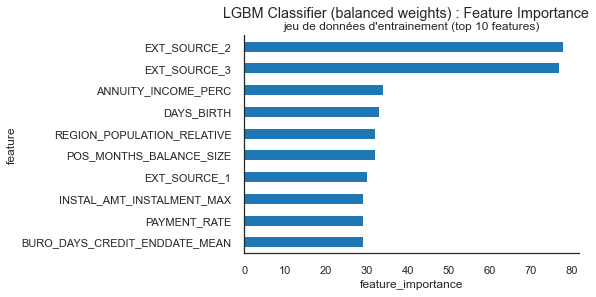

In [154]:
plot_feature_importances(best_model, x_train_prep, lgbm_best_model_name)

EXT_SOURCE_2                     78
EXT_SOURCE_3                     77
ANNUITY_INCOME_PERC              34
DAYS_BIRTH                       33
REGION_POPULATION_RELATIVE       32
POS_MONTHS_BALANCE_SIZE          32
EXT_SOURCE_1                     30
INSTAL_AMT_INSTALMENT_MAX        29
PAYMENT_RATE                     29
BURO_DAYS_CREDIT_ENDDATE_MEAN    29
dtype: int32
"LGBM_Classifier_(balanced_weights)-_Feature_Importance_entrainement.png"


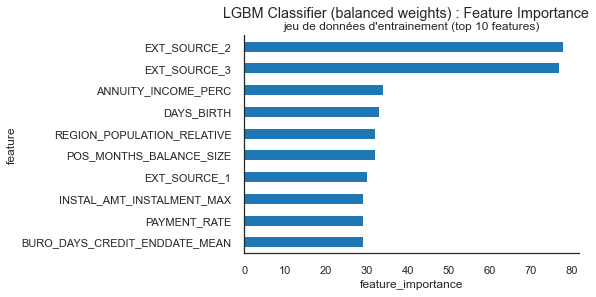

In [155]:
plot_feature_importances(lgbm_best_model, x_train_prep, lgbm_best_model_name)


### (permutation-based) feature importance (sklearn.inspection.permutation_importance)

- computé sur le jeu de test
- basé sur permutation de valeurs dans chaque feature pour voir l'impact sur la prédiction

- <https://scikit-learn.org/stable/modules/permutation_importance.html>
- <https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html>


In [156]:
from sklearn.inspection import permutation_importance


def evaluate_permutation_importance(model, x_val, y_val, scoring='roc_auc', model_name='',
                                    n_jobs=1):
    """Évaluer et plot feature importance pour jeu de test (x_val, y_val)"""
    nb_features = len(x_val.columns)

    # Linear regressors
    nb_repeats = 20
    importance = permutation_importance(
        model,
        x_val,
        y_val,
        scoring=scoring,
        n_jobs=n_jobs,
        random_state=12,
        n_repeats=nb_repeats,
    )

    # save detailed importance
    df_imp = pd.DataFrame(
        {'feature': x_val.columns,
         'importances_mean': importance['importances_mean'],
         'importances_std': importance['importances_std'],
         }
    )
    df_imp = df_imp.sort_values(by='importances_mean', ascending=False)
    nb = min(nb_features, 10)
    data = df_imp.head(nb)
    x = data['importances_mean']
    y = data['feature']
    err_bar = np.array(data['importances_std']*2)
    print(err_bar)
    ax = sns.barplot(data=df_imp.head(10), y='feature', x='importances_mean')
    plt.errorbar(x, y, xerr=err_bar, fmt=".", color="red")
    plt.suptitle(f'{model_name} Feature Importance')
    ax.set_title(f'jeu de données test ({nb_repeats} permutations)')
    ax.set_xlabel('importance (mean)')
    add_text(ax, 0.3, 0.12, s=f'scoring = {scoring}')
    add_text(ax, 0.3, 0.04,
             s=f'error_bar = mean +/- 2*std (n_repeats={nb_repeats})', fontstyle='italic')
    sns.despine()
    to_png(f'{model_name} - Permutation Importance entrainement (scoring = {scoring})')
    plt.show()


[0.02272918 0.0126188  0.00748597 0.00912953 0.00550158 0.00409232
 0.00558162 0.0055577  0.00470511 0.00404715]
"LGBM_Classifier_(balanced_weights)_-_Permutation_Importance_entrainement_(scoring_=_roc_auc).png"


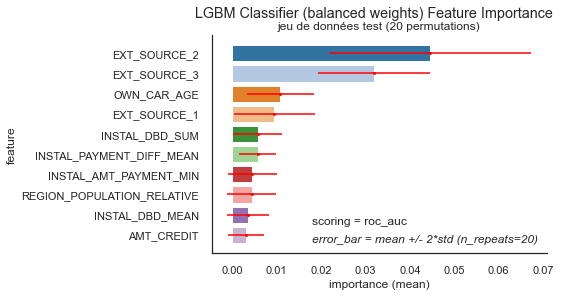

In [157]:
evaluate_permutation_importance(
    lgbm_best_model, x_test_prep, y_test, model_name=lgbm_best_model_name, scoring='roc_auc')


[0.02236295 0.01775952 0.00936404 0.00946771 0.00775593 0.00968073
 0.00613599 0.00621749 0.00547214 0.0103518 ]
"LGBM_Classifier_(balanced_weights)_-_Permutation_Importance_entrainement_(scoring_=_make_scorer(custom_credit_score)).png"


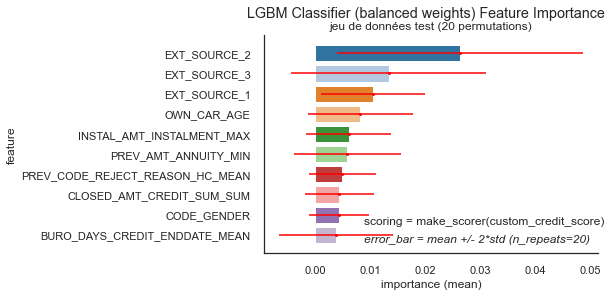

In [158]:
evaluate_permutation_importance(
    lgbm_best_model, x_test_prep, y_test, model_name=lgbm_best_model_name, scoring=bank_scorer)


# SHAP - Interpretabilité


In [159]:
import shap
# load JS visualization code to notebook. Without this, the SHAP plots won't be displayed
shap.initjs()
# lgbm_best_model.predict_proba(x_test_prep)
# Train shap explainer using train set

explainer = shap.TreeExplainer(lgbm_best_model, x_train_prep)


Descativer check_additivity, car les explications sont basées sur le jeu de données train 

In [160]:
lgbm_shap_values = explainer.shap_values(x_test_prep, check_additivity=False)


### Feature importances from shap


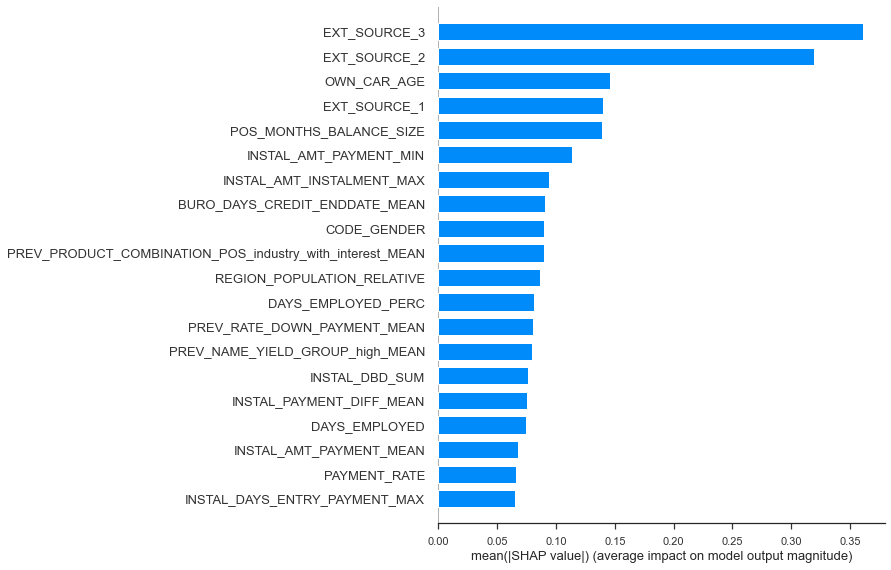

In [161]:
shap.summary_plot(lgbm_shap_values,
                  x_test_prep, plot_type="bar")


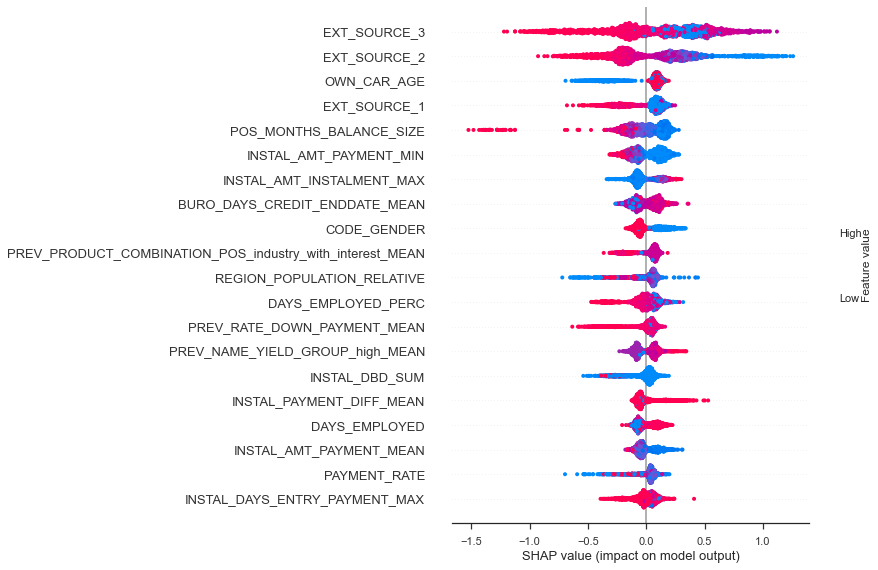

In [162]:
shap.summary_plot(lgbm_shap_values, x_test_prep)


### Explication pour le premier ligne de x_test

In [163]:
shap.force_plot(explainer.expected_value,
                lgbm_shap_values[0, :], x_test_prep.iloc[0, :])


### Explication pour les premiers 100 lignes de x_test

In [164]:
shap.force_plot(explainer.expected_value,
                lgbm_shap_values[:100, :], x_test_prep.iloc[:100, :])
